Import Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.feature_selection import f_regression
import math
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional

## Data Pre-processing

Import Data

In [2]:
# Read data input files
date_format_1 = lambda x: datetime.strptime(x, '%Y-%m-%d')
date_format_2 = lambda x: datetime.strptime(x, '%d/%m/%Y')

df_price_000969_SZ = pd.read_csv("Datasets/Advanced Technology _ Materials Co., Ltd. (000969.SZ) Stock Prices.csv", parse_dates=['Date'], date_parser=date_format_1)
df_price_ASM_AX = pd.read_csv("Datasets/ASM.AX.csv", parse_dates=['Date'], date_parser=date_format_2)
df_price_000970_SZ = pd.read_csv("Datasets/Beijing Zhong Ke San Huan High-Tech Co., Ltd. (000970.SZ) Stock Prices.csv", parse_dates=['Date'], date_parser=date_format_1)
df_price_300127_SZ = pd.read_csv("Datasets/Chengdu Galaxy Magnets Co.,Ltd. (300127.SZ) Stock Prices.csv", parse_dates=['Date'], date_parser=date_format_1)
df_price_000795_SZ = pd.read_csv("Datasets/Innuovo Technology Co., Ltd. (000795.SZ) Stock Prices.csv", parse_dates=['Date'], date_parser=date_format_1)
df_interpolated_ev_sales = pd.read_csv("Datasets/Interpolated EV Sales.csv", parse_dates=['Date'], date_parser=date_format_1)
df_interpolated_wind_energy = pd.read_csv("Datasets/Interpolated Wind Energy.csv", parse_dates=['Date'], date_parser=date_format_1)
df_spline_interpolated_ev_sales = pd.read_csv("Datasets/Spline Interpolated EV Sales.csv", parse_dates=['Date'], date_parser=date_format_1)
df_spline_interpolated_wind_energy = pd.read_csv("Datasets/Spline Interpolated Wind Energy.csv", parse_dates=['Date'], date_parser=date_format_1)
df_price_LYC_AX = pd.read_csv("Datasets/LYC.AX.csv", parse_dates=['Date'], date_parser=date_format_1)
df_price_MP = pd.read_csv("Datasets/MP.csv", parse_dates=['Date'], date_parser=date_format_1)
df_price_NEO_TO = pd.read_csv("Datasets/NEO.TO.csv", parse_dates=['Date'], date_parser=date_format_2)
df_price_neodymium = pd.read_excel("Datasets/Neodymium Prices.xlsx", parse_dates=['Date'], date_parser=date_format_1)
df_price_600366_SS = pd.read_csv("Datasets/Ningbo Yunsheng Co., Ltd. (600366.SS) Stock Prices.csv", parse_dates=['Date'], date_parser=date_format_1)
df_price_600259_SS = pd.read_csv("Datasets/Rising Nonferrous Metals Share Co.,Ltd. (600259.SS) Stock Prices.csv", parse_dates=['Date'], date_parser=date_format_1)
df_price_002057_SZ = pd.read_csv("Datasets/Sinosteel New Materials Co., Ltd. (002057.SZ) Stock Prices.csv", parse_dates=['Date'], date_parser=date_format_1)
df_price_UUUU = pd.read_csv("Datasets/UUUU.csv", parse_dates=['Date'], date_parser=date_format_1)
df_price_300224_SZ = pd.read_csv("Datasets/Yantai Zhenghai Magnetic Material Co., Ltd. (300224.SZ) Stock Prices.csv", parse_dates=['Date'], date_parser=date_format_1)
df_price_002249_SZ = pd.read_csv("Datasets/Zhongshan Broad-Ocean Motor Co., Ltd. (002249.SZ) Stock Prices.csv", parse_dates=['Date'], date_parser=date_format_1)
df_price_USD_CNY = pd.read_csv("Datasets/USD_CNY.csv", parse_dates=['Date'], date_parser=date_format_2)


In [3]:
# Naming of data columns
all_df_price_names = [df_price_000969_SZ, df_price_ASM_AX, df_price_000970_SZ, df_price_300127_SZ, df_price_000795_SZ, df_price_LYC_AX, df_price_MP, df_price_NEO_TO, df_price_600366_SS, df_price_600259_SS, df_price_002057_SZ, df_price_UUUU, df_price_300224_SZ, df_price_002249_SZ, df_price_USD_CNY]
all_price_names = ["000969_SZ", "ASM_AX", "000970_SZ", "300127_SZ", "000795_SZ", "LYC_AX", "MP", "NEO_TO", "600366_SS", "600259_SS", "002057_SZ", "UUUU", "300224_SZ", "002249_SZ", "USD_CNY"]
all_df_other_names = [df_interpolated_ev_sales, df_interpolated_wind_energy, df_spline_interpolated_ev_sales, df_spline_interpolated_wind_energy]
all_other_names = ["ev_sales", "wind_energy", "spline_ev_sales", "spline_wind_energy"]

In [4]:
# Changing date column to datetime type
for name in all_df_price_names: 
    name["Date"] = pd.to_datetime(name["Date"])
for name in all_df_other_names:
    name["Date"] = pd.to_datetime(name["Date"])

df_price_neodymium["Date"] = pd.to_datetime(df_price_neodymium["Date"])

In [5]:
# Extracting relevant columns from data inputs
df = pd.DataFrame()
for i in range(len(all_df_price_names)): 
    relevant_df = all_df_price_names[i][["Date", "Adj Close", "Volume"]]
    relevant_df = relevant_df.rename(columns = {"Adj Close" : f"Adj Close {all_price_names[i]}", "Volume" : f"Volume {all_price_names[i]}"})
    relevant_df = relevant_df.set_index("Date")
    df = df.join(relevant_df, how = "outer")

for i in range(len(all_df_other_names)):
    try :
        relevant_df = all_df_other_names[i][["Date", "Interpolated Demand", "Interpolated Total Value"]]
        relevant_df = relevant_df.rename(columns = {"Interpolated Demand": f"Interpolated Demand {all_other_names[i]}", "Interpolated Total Value" : f"Interpolated Value {all_other_names[i]}"})
        relevant_df = relevant_df.set_index("Date")
        df = df.join(relevant_df, how = "outer")
    except:
        relevant_df = all_df_other_names[i][["Date", "Interpolated Value"]]
        relevant_df = relevant_df.rename(columns = {"Interpolated Value" : f"Interpolated Value {all_other_names[i]}"})
        relevant_df = relevant_df.set_index("Date")
        df = df.join(relevant_df, how = "outer")

In [6]:
# Drop trading volume column of Neodymium
df = df.drop(columns=["Volume USD_CNY"])

In [7]:
# Combine trading price column of Neodymium
df_price_neodymium = df_price_neodymium.set_index("Date")
df = df.join(df_price_neodymium, how = "left")

In [8]:
# Look at data between 4 Jan 2021 and 31 Dec 2022
df = df[df.index > "2021-01-04"]
df = df[df.index <= "2022-12-31"]
df = df.fillna(method = "ffill")
df = df.tail(-2)
df

Adj Close 000969_SZ  Volume 000969_SZ  Adj Close ASM_AX  \
Date                                                                  
2021-01-07             6.514151        13426712.0          6.110046   
2021-01-08             6.753568        20120275.0          5.650794   
2021-01-09             6.753568        20120275.0          5.650794   
2021-01-10             6.753568        20120275.0          5.650794   
2021-01-11             6.863301        22474564.0          4.722307   
...                         ...               ...               ...   
2022-12-27             8.140000        33289617.0          1.420000   
2022-12-28             7.930000        21105880.0          1.370000   
2022-12-29             7.820000        16415578.0          1.355000   
2022-12-30             7.750000        18526065.0          1.435000   
2022-12-31             7.750000        18526065.0          1.435000   

            Volume ASM_AX  Adj Close 000970_SZ  Volume 000970_SZ  \
Date                                                               
2021-01-07       323868.0             9.661907        18112475.0   
2021-01-08      1093415.0             9.711353        18551280.0   
2021-01-09      1093415.0             9.711353        18551280.0   
2021-01-10      1093415.0             9.711353        18551280.0   
2021-01-11      2118657.0             9.820137        35900319.0   
...                   ...                  ...               ...   
2022-12-27       302009.0            13.850000        90710906.0   
2022-12-28       275839.0            13.950000        95619502.0   
2022-12-29       251332.0            13.600000        41254182.0   
2022-12-30       356962.0            13.640000        38633574.0   
2022-12-31       356962.0            13.640000        38633574.0   

            Adj Close 300127_SZ  Volume 300127_SZ  Adj Close 000795_SZ  \
Date                                                                     
2021-01-07            16.215036         5105801.0                 5.36   
2021-01-08            15.785563         5342705.0                 5.23   
2021-01-09            15.785563         5342705.0                 5.23   
2021-01-10            15.785563         5342705.0                 5.23   
2021-01-11            15.947805         5330195.0                 5.23   
...                         ...               ...                  ...   
2022-12-27            15.970000         6278960.0                 6.68   
2022-12-28            15.690000         2549844.0                 6.72   
2022-12-29            15.400000         1744800.0                 6.55   
2022-12-30            15.190000         1690400.0                 6.49   
2022-12-31            15.190000         1690400.0                 6.49   

            Volume 000795_SZ  ...  Adj Close 002249_SZ  Volume 002249_SZ  \
Date                          ...                                          
2021-01-07        15409792.0  ...             4.118569        57241206.0   
2021-01-08        18467772.0  ...             4.203585        68194148.0   
2021-01-09        18467772.0  ...             4.203585        68194148.0   
2021-01-10        18467772.0  ...             4.203585        68194148.0   
2021-01-11        19406651.0  ...             3.901305        73128902.0   
...                      ...  ...                  ...               ...   
2022-12-27        17859983.0  ...             5.190000        10419563.0   
2022-12-28        19388733.0  ...             5.140000         7233929.0   
2022-12-29        11511608.0  ...             5.120000         8292740.0   
2022-12-30         9554400.0  ...             5.120000         8649400.0   
2022-12-31         9554400.0  ...             5.120000         8649400.0   

            Adj Close USD_CNY  Interpolated Demand ev_sales  \
Date                                                          
2021-01-07             6.4607                  23319.518876   
2021-01-08             6.4772                  23235.899657   

In [9]:
# Ensure no null values
df.isnull().values.any()

False

In [10]:
# Export combined data
df.to_csv("combined_raw_variables.csv")

## Feature Selection

Pearson Correlation

In [11]:
# View Pearson correlation of features
df.corr(numeric_only=True)

Adj Close 000969_SZ  Volume 000969_SZ  \
Adj Close 000969_SZ                               1.000000          0.579311   
Volume 000969_SZ                                  0.579311          1.000000   
Adj Close ASM_AX                                  0.529452          0.314831   
Volume ASM_AX                                     0.131053          0.086582   
Adj Close 000970_SZ                               0.521078          0.050751   
Volume 000970_SZ                                  0.410881          0.268725   
Adj Close 300127_SZ                               0.844792          0.441639   
Volume 300127_SZ                                  0.526466          0.609319   
Adj Close 000795_SZ                               0.554393          0.104519   
Volume 000795_SZ                                  0.532215          0.308398   
Adj Close LYC_AX                                  0.402475         -0.108830   
Volume LYC_AX                                    -0.139290         -0.034422   
Adj Close MP                                      0.171631          0.007671   
Volume MP                                        -0.303897         -0.053614   
Adj Close NEO_TO                                  0.324169          0.339381   
Volume NEO_TO                                    -0.041981         -0.083239   
Adj Close 600366_SS                               0.753676          0.152199   
Volume 600366_SS                                  0.503703          0.478763   
Adj Close 600259_SS                               0.752192          0.270090   
Volume 600259_SS                                  0.202300          0.334416   
Adj Close 002057_SZ                               0.378862         -0.009819   
Volume 002057_SZ                                  0.447557          0.210568   
Adj Close UUUU                                    0.193199         -0.074925   
Volume UUUU                                      -0.164274         -0.110060   
Adj Close 300224_SZ                               0.686880          0.328460   
Volume 300224_SZ                                  0.516359          0.494930   
Adj Close 002249_SZ                               0.889830          0.326639   
Volume 002249_SZ                                  0.398178          0.421862   
Adj Close USD_CNY                                -0.152099         -0.196998   
Interpolated Demand ev_sales                      0.229188         -0.082652   
Interpolated Value ev_sales                       0.183464         -0.080543   
Interpolated Value wind_energy                   -0.019403         -0.225755   
Interpolated Demand spline_ev_sales               0.227387         -0.059468   
Interpolated Value spline_ev_sales                0.185149         -0.056556   
Interpolated Value spline_wind_energy            -0.028942         -0.229495   
Price (CNY/T)                                     0.191945         -0.259983   

                                       Adj Close ASM_AX  Volume ASM_AX  \
Adj Close 000969_SZ                            0.529452       0.131053   
Volume 000969_SZ                               0.314831       0.086582   
Adj Close ASM_AX                               1.000000       0.000030   
Volume ASM_AX                                  0.000030       1.000000   
Adj Close 000970_SZ                           -0.181245       0.094679   
Volume 000970_SZ                               0.102289       0.038722   
Adj Close 300127_SZ                            0.739563       0.070694   
Volume 300127_SZ                               0.473429       0.119554   
Adj Close 000795_SZ                            0.005247       0.062488   
Volume 000795_SZ                               0.340320       0.039663   
Adj Close LYC_AX                               0.089313       0.040314   
Volume LYC_AX                                  0.106641       0.104636   
Adj Close MP                                   0.493551      -0.066230   
Volume MP                                 

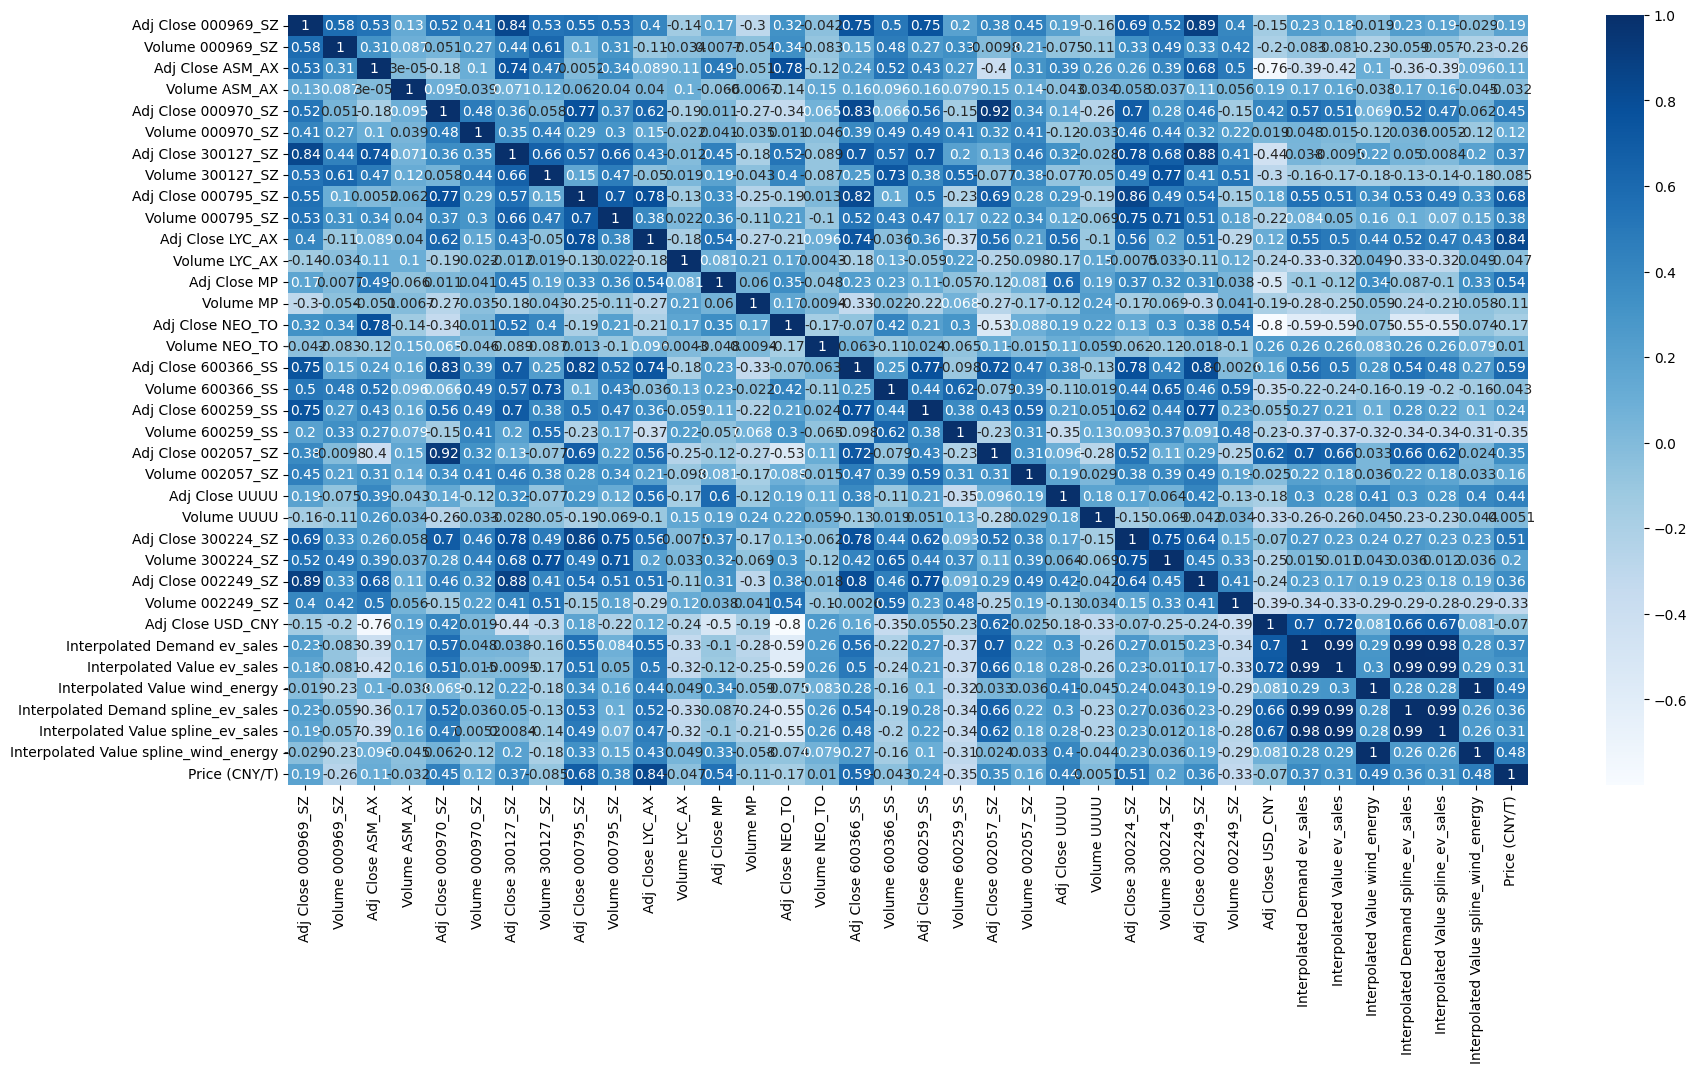

In [12]:
# View Pearson correlation of features on heatmap
plt.figure(figsize = (20,10))
ax =  sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues')

In [13]:
# View features that are have a Pearson correlation with Neodymium price greater than 0.4
price_corr = df.corr(numeric_only=True)["Price (CNY/T)"]
price_corr[price_corr > 0.4].sort_values(ascending=False)

Price (CNY/T)                            1.000000
Adj Close LYC_AX                         0.836410
Adj Close 000795_SZ                      0.682640
Adj Close 600366_SS                      0.591330
Adj Close MP                             0.539889
Adj Close 300224_SZ                      0.505492
Interpolated Value wind_energy           0.485724
Interpolated Value spline_wind_energy    0.476519
Adj Close 000970_SZ                      0.450602
Adj Close UUUU                           0.439172
Name: Price (CNY/T), dtype: float64

In [14]:
df

Adj Close 000969_SZ  Volume 000969_SZ  Adj Close ASM_AX  \
Date                                                                  
2021-01-07             6.514151        13426712.0          6.110046   
2021-01-08             6.753568        20120275.0          5.650794   
2021-01-09             6.753568        20120275.0          5.650794   
2021-01-10             6.753568        20120275.0          5.650794   
2021-01-11             6.863301        22474564.0          4.722307   
...                         ...               ...               ...   
2022-12-27             8.140000        33289617.0          1.420000   
2022-12-28             7.930000        21105880.0          1.370000   
2022-12-29             7.820000        16415578.0          1.355000   
2022-12-30             7.750000        18526065.0          1.435000   
2022-12-31             7.750000        18526065.0          1.435000   

            Volume ASM_AX  Adj Close 000970_SZ  Volume 000970_SZ  \
Date                                                               
2021-01-07       323868.0             9.661907        18112475.0   
2021-01-08      1093415.0             9.711353        18551280.0   
2021-01-09      1093415.0             9.711353        18551280.0   
2021-01-10      1093415.0             9.711353        18551280.0   
2021-01-11      2118657.0             9.820137        35900319.0   
...                   ...                  ...               ...   
2022-12-27       302009.0            13.850000        90710906.0   
2022-12-28       275839.0            13.950000        95619502.0   
2022-12-29       251332.0            13.600000        41254182.0   
2022-12-30       356962.0            13.640000        38633574.0   
2022-12-31       356962.0            13.640000        38633574.0   

            Adj Close 300127_SZ  Volume 300127_SZ  Adj Close 000795_SZ  \
Date                                                                     
2021-01-07            16.215036         5105801.0                 5.36   
2021-01-08            15.785563         5342705.0                 5.23   
2021-01-09            15.785563         5342705.0                 5.23   
2021-01-10            15.785563         5342705.0                 5.23   
2021-01-11            15.947805         5330195.0                 5.23   
...                         ...               ...                  ...   
2022-12-27            15.970000         6278960.0                 6.68   
2022-12-28            15.690000         2549844.0                 6.72   
2022-12-29            15.400000         1744800.0                 6.55   
2022-12-30            15.190000         1690400.0                 6.49   
2022-12-31            15.190000         1690400.0                 6.49   

            Volume 000795_SZ  ...  Adj Close 002249_SZ  Volume 002249_SZ  \
Date                          ...                                          
2021-01-07        15409792.0  ...             4.118569        57241206.0   
2021-01-08        18467772.0  ...             4.203585        68194148.0   
2021-01-09        18467772.0  ...             4.203585        68194148.0   
2021-01-10        18467772.0  ...             4.203585        68194148.0   
2021-01-11        19406651.0  ...             3.901305        73128902.0   
...                      ...  ...                  ...               ...   
2022-12-27        17859983.0  ...             5.190000        10419563.0   
2022-12-28        19388733.0  ...             5.140000         7233929.0   
2022-12-29        11511608.0  ...             5.120000         8292740.0   
2022-12-30         9554400.0  ...             5.120000         8649400.0   
2022-12-31         9554400.0  ...             5.120000         8649400.0   

            Adj Close USD_CNY  Interpolated Demand ev_sales  \
Date                                                          
2021-01-07             6.4607                  23319.518876   
2021-01-08             6.4772                  23235.899657   

Spearman Correlation

In [15]:
# View Spearman correlation of features on heatmap
df.corr(method="spearman")

Adj Close 000969_SZ  Volume 000969_SZ  \
Adj Close 000969_SZ                               1.000000          0.559876   
Volume 000969_SZ                                  0.559876          1.000000   
Adj Close ASM_AX                                  0.445941          0.326796   
Volume ASM_AX                                     0.091951         -0.032189   
Adj Close 000970_SZ                               0.591485          0.014202   
Volume 000970_SZ                                  0.542432          0.382304   
Adj Close 300127_SZ                               0.851360          0.360185   
Volume 300127_SZ                                  0.481451          0.577673   
Adj Close 000795_SZ                               0.510008         -0.040069   
Volume 000795_SZ                                  0.529529          0.254009   
Adj Close LYC_AX                                  0.392600         -0.199550   
Volume LYC_AX                                    -0.054164          0.008800   
Adj Close MP                                      0.207603         -0.000182   
Volume MP                                        -0.364583         -0.025627   
Adj Close NEO_TO                                  0.296170          0.451088   
Volume NEO_TO                                    -0.000402         -0.119618   
Adj Close 600366_SS                               0.783472          0.173186   
Volume 600366_SS                                  0.491180          0.514630   
Adj Close 600259_SS                               0.799331          0.303909   
Volume 600259_SS                                  0.190536          0.436734   
Adj Close 002057_SZ                               0.462759         -0.048240   
Volume 002057_SZ                                  0.574703          0.273332   
Adj Close UUUU                                    0.204860         -0.136055   
Volume UUUU                                      -0.227159         -0.116928   
Adj Close 300224_SZ                               0.663434          0.192424   
Volume 300224_SZ                                  0.467405          0.381894   
Adj Close 002249_SZ                               0.887251          0.293507   
Volume 002249_SZ                                  0.311698          0.617799   
Adj Close USD_CNY                                -0.231072         -0.139922   
Interpolated Demand ev_sales                      0.257161         -0.196728   
Interpolated Value ev_sales                       0.196381         -0.190554   
Interpolated Value wind_energy                   -0.004332         -0.352961   
Interpolated Demand spline_ev_sales               0.245689         -0.152260   
Interpolated Value spline_ev_sales                0.187600         -0.151909   
Interpolated Value spline_wind_energy            -0.014182         -0.356616   
Price (CNY/T)                                     0.233295         -0.338898   

                                       Adj Close ASM_AX  Volume ASM_AX  \
Adj Close 000969_SZ                            0.445941       0.091951   
Volume 000969_SZ                               0.326796      -0.032189   
Adj Close ASM_AX                               1.000000       0.020433   
Volume ASM_AX                                  0.020433       1.000000   
Adj Close 000970_SZ                           -0.196297       0.181610   
Volume 000970_SZ                               0.109258       0.197327   
Adj Close 300127_SZ                            0.678399       0.110450   
Volume 300127_SZ                               0.555030       0.116091   
Adj Close 000795_SZ                           -0.095170       0.100911   
Volume 000795_SZ                               0.356328       0.114144   
Adj Close LYC_AX                               0.080888       0.090512   
Volume LYC_AX                                  0.218664       0.163578   
Adj Close MP                                   0.575807       0.016986   
Volume MP                                 

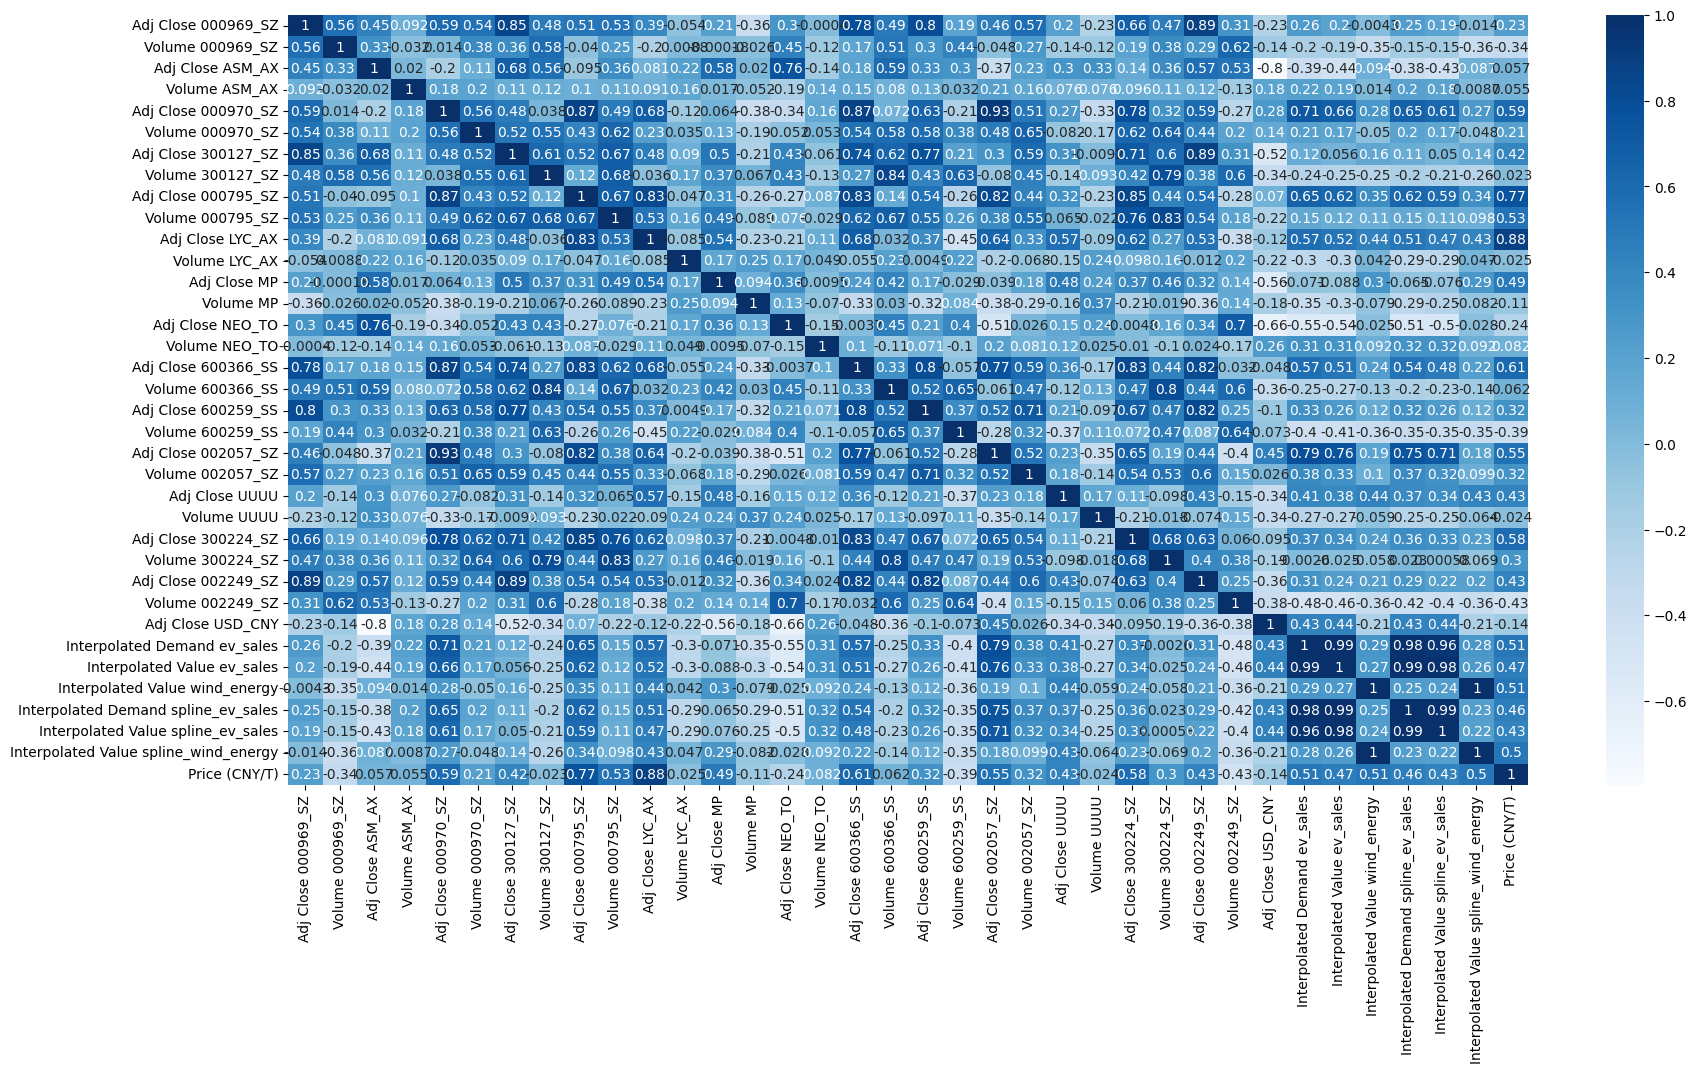

In [16]:
# View Spearman correlation of features on heatmap
plt.figure(figsize = (20,10))
ax =  sns.heatmap(df.corr(numeric_only=True, method="spearman"), annot=True, cmap='Blues')

In [17]:
# View features that are have a Spearman correlation with Neodymium price greater than 0.4
price_corr = df.corr(method="spearman")["Price (CNY/T)"]
price_corr[price_corr > 0.4].sort_values(ascending=False)

Price (CNY/T)                            1.000000
Adj Close LYC_AX                         0.881924
Adj Close 000795_SZ                      0.767488
Adj Close 600366_SS                      0.605624
Adj Close 000970_SZ                      0.592998
Adj Close 300224_SZ                      0.576851
Adj Close 002057_SZ                      0.548709
Volume 000795_SZ                         0.532767
Interpolated Value wind_energy           0.514201
Interpolated Demand ev_sales             0.512387
Interpolated Value spline_wind_energy    0.502670
Adj Close MP                             0.493932
Interpolated Value ev_sales              0.472142
Interpolated Demand spline_ev_sales      0.463922
Adj Close 002249_SZ                      0.429195
Adj Close UUUU                           0.428445
Interpolated Value spline_ev_sales       0.427258
Adj Close 300127_SZ                      0.415085
Name: Price (CNY/T), dtype: float64

F-test

In [18]:
# Conduct F-test to determine relevancy of features
X = df.loc[:, df.columns != 'Price (CNY/T)']
y = df['Price (CNY/T)']

f_values, _ = f_regression(X, y)
threshold = 100

selected_features = X.columns[f_values > threshold]
selected_features

Index(['Adj Close 000970_SZ', 'Adj Close 300127_SZ', 'Adj Close 000795_SZ',
       'Volume 000795_SZ', 'Adj Close LYC_AX', 'Adj Close MP',
       'Adj Close 600366_SS', 'Adj Close 002057_SZ', 'Adj Close UUUU',
       'Adj Close 300224_SZ', 'Adj Close 002249_SZ',
       'Interpolated Demand ev_sales', 'Interpolated Value wind_energy',
       'Interpolated Demand spline_ev_sales',
       'Interpolated Value spline_wind_energy'],
      dtype='object')

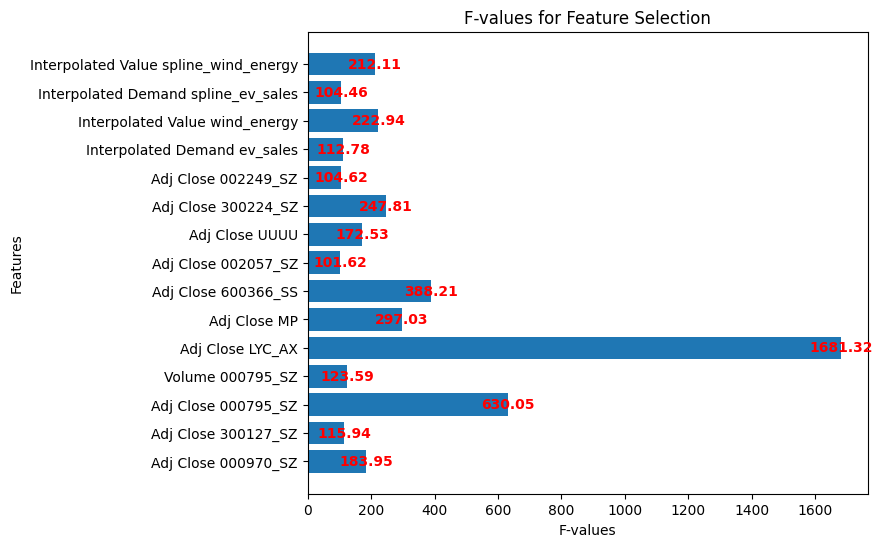

In [19]:
# View F-values on bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bar_plot = ax.barh(selected_features, f_values[f_values > threshold])

for i, v in enumerate(f_values[f_values > threshold]):
    ax.text(v + 0.1, i, str(round(v, 2)), color='red', fontweight='bold', ha='center', va='center')

plt.subplots_adjust(left=0.2)
ax.set_xlabel('F-values')
ax.set_ylabel('Features')
ax.set_title('F-values for Feature Selection')

plt.show()

Linear Regression

In [20]:
df_columns_list = df.columns.tolist()
predicted = df_columns_list[-1]
variables = df_columns_list[0:-1]
variables_string = ""
for var in variables:
    variables_string = variables_string + (var + ",")
# variables_string = variables_string[0:-1] ## Remove the last comma
variables_string = variables_string[0:19] 
linear_regression_formula = f"{variables_string} ~ {predicted}"
variables_string

'Adj Close 000969_SZ'

In [21]:
model = sm.OLS(df["Price (CNY/T)"], df.loc[:, df.columns != "Price (CNY/T)"]).fit()

In [22]:
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:          Price (CNY/T)   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              2796.
Date:                Sat, 19 Aug 2023   Prob (F-statistic):                        0.00
Time:                        18:40:04   Log-Likelihood:                         -9209.5
No. Observations:                 724   AIC:                                  1.849e+04
Df Residuals:                     689   BIC:                                  1.865e+04
Df Model:                          35                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

## Model Building

In [23]:
print(df.index[0], "- to -", df.index[174])
print(df.index[175], "- to -", df.index[358])
print(df.index[359], "- to -", df.index[539])
print(df.index[540], "- to -", df.index[723])

2021-01-07 00:00:00 - to - 2021-06-30 00:00:00
2021-07-01 00:00:00 - to - 2021-12-31 00:00:00
2022-01-01 00:00:00 - to - 2022-06-30 00:00:00
2022-07-01 00:00:00 - to - 2022-12-31 00:00:00


In [24]:
for i in [0, 25, 53, 84, 114, 145, 
          175, 206, 237, 267, 298, 328, 
          359, 390, 418, 449, 479, 510, 
          540, 571, 602, 632, 663, 693]:
    print(df.index[i])

2021-01-07 00:00:00
2021-02-01 00:00:00
2021-03-01 00:00:00
2021-04-01 00:00:00
2021-05-01 00:00:00
2021-06-01 00:00:00
2021-07-01 00:00:00
2021-08-01 00:00:00
2021-09-01 00:00:00
2021-10-01 00:00:00
2021-11-01 00:00:00
2021-12-01 00:00:00
2022-01-01 00:00:00
2022-02-01 00:00:00
2022-03-01 00:00:00
2022-04-01 00:00:00
2022-05-01 00:00:00
2022-06-01 00:00:00
2022-07-01 00:00:00
2022-08-01 00:00:00
2022-09-01 00:00:00
2022-10-01 00:00:00
2022-11-01 00:00:00
2022-12-01 00:00:00


Variable Selection

In [25]:
# Possible features from feature selection
cols_correlation = ["Adj Close 000970_SZ", "Adj Close 000795_SZ", "Adj Close LYC_AX", "Adj Close 600366_SS", "Adj Close 002057_SZ", 
        "Adj Close UUUU", "Adj Close 300224_SZ", "Interpolated Demand spline_ev_sales", "Interpolated Value spline_ev_sales", "Price (CNY/T)"]

"""
'Adj Close LYC_AX',
'Adj Close 000795_SZ',
'Adj Close 600366_SS',
'Adj Close 000970_SZ',
'Adj Close 300224_SZ',
'Adj Close 002057_SZ',
'Volume 000795_SZ',
'Interpolated Value wind_energy',
'Interpolated Demand ev_sales',
'Interpolated Value spline_wind_energy',
'Adj Close MP',
'Interpolated Value ev_sales',
'Interpolated Demand spline_ev_sales',
'Adj Close 002249_SZ',
'Adj Close UUUU',
'Interpolated Value spline_ev_sales',
'Adj Close 300127_SZ'
 """


# additional "Interpolated Demand spline_ev_sales", "Interpolated Value spline_ev_sales"

cols_ftest = ['Adj Close 000970_SZ', 'Adj Close 300127_SZ', 'Adj Close 000795_SZ', 'Volume 000795_SZ', 'Adj Close LYC_AX', 'Adj Close MP',
        'Adj Close 600366_SS', 'Adj Close 002057_SZ', 'Adj Close UUUU', 'Adj Close 300224_SZ', 'Adj Close 002249_SZ',
        'Interpolated Demand ev_sales', 'Interpolated Value wind_energy','Interpolated Demand spline_ev_sales','Interpolated Value spline_wind_energy']

# additional 'Adj Close 300127_SZ', 'Volume 000795_SZ', 'Adj Close MP', 'Adj Close 002249_SZ', 'Interpolated Demand ev_sales', 'Interpolated Value wind_energy','Interpolated Demand spline_ev_sales','Interpolated Value spline_wind_energy'

In [46]:
# Final features selected
#added Adj Close MP and Interpolated Demand ev_sales, removed Interpolated Value spline_ev_sales

#cols =  ["Adj Close MP", "Adj Close 000970_SZ", "Adj Close 000795_SZ", "Adj Close LYC_AX", "Adj Close 600366_SS", "Adj Close 002057_SZ", 
#        "Adj Close UUUU", "Adj Close 300224_SZ", "Interpolated Demand spline_ev_sales", "Interpolated Demand ev_sales", "Price (CNY/T)"]


cols= ['Adj Close LYC_AX',
        'Adj Close 000795_SZ',
        'Adj Close 600366_SS',
        'Adj Close 000970_SZ',
        'Adj Close 300224_SZ',
        'Adj Close 002057_SZ',
        'Volume 000795_SZ',
        'Interpolated Value wind_energy',
        'Interpolated Demand ev_sales',
        'Adj Close MP',
        'Adj Close 002249_SZ',
        'Adj Close UUUU',
        'Adj Close 300127_SZ',
        'Price (CNY/T)']


cols = ['Adj Close LYC_AX',
        'Adj Close 600366_SS',
        'Adj Close MP',
        'Interpolated Value wind_energy',
        'Interpolated Demand ev_sales',
        'Price (CNY/T)']

In [44]:
model = sm.OLS(df["Price (CNY/T)"], df[cols]).fit()

In [45]:
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:          Price (CNY/T)   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          5.242e+32
Date:                Sat, 19 Aug 2023   Prob (F-statistic):                        0.00
Time:                        18:45:02   Log-Likelihood:                          14535.
No. Observations:                 724   AIC:                                 -2.906e+04
Df Residuals:                     718   BIC:                                 -2.903e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------

1-Day ARIMA Forecast Model

In [67]:
from pmdarima.arima import auto_arima

one_day_pred = pd.Series([])
y = df['Price (CNY/T)']
train_size = int(len(y) * 0.8)
train_data, test_data = y[:train_size], y[train_size:]

for i in range(len(test_data)):

    training_window = y[i+train_size-30 : i+train_size]

    arima_model = auto_arima(training_window)
    arima_model.summary()

    one_day_pred = one_day_pred.append(arima_model.predict(n_periods = 1))


C:\Users\brian\AppData\Local\Temp\ipykernel_2088\3735661489.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  one_day_pred = pd.Series([])
C:\Users\brian\AppData\Local\Temp\ipykernel_2088\3735661489.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  one_day_pred = one_day_pred.append(arima_model.predict(n_periods = 1))
C:\Users\brian\AppData\Local\Temp\ipykernel_2088\3735661489.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  one_day_pred = one_day_pred.append(arima_model.predict(n_periods = 1))
C:\Users\brian\AppData\Local\Temp\ipykernel_2088\3735661489.py:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat in

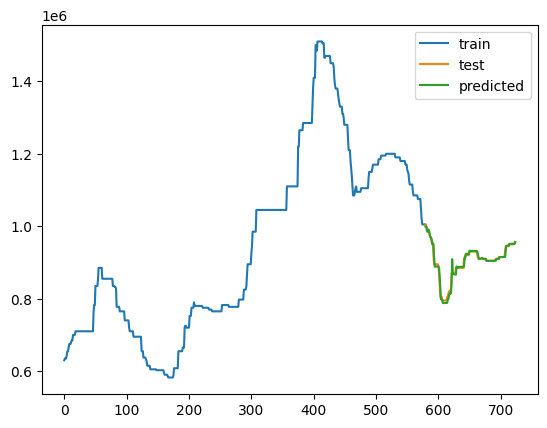

In [68]:
plt.plot(range(len(train_data)), train_data, label='train')
plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='test')
plt.plot(range(len(train_data), len(train_data) + len(one_day_pred)),one_day_pred, label = "predicted")
plt.legend()

plt.show()

In [69]:
# Calculate model performance 
r2score = r2_score(test_data, one_day_pred,)
mape = mean_absolute_percentage_error(test_data, one_day_pred,)
mae = mean_absolute_error(test_data, one_day_pred,)
rmse = sqrt(mean_squared_error(test_data, one_day_pred,))

print('1-Day Forecast ARIMA Model')
print('Test R2: %.3f' % r2score)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)

1-Day Forecast ARIMA Model
Test R2: 0.971
Test MAE: 4671.064
Test MAPE: 0.005
Test RMSE: 8057.228


5-Day ARIMA Forecast Model

In [70]:
five_day_pred = pd.Series([])
train_size = int(len(y) * 0.8)
train_data, test_data = y[:train_size], y[train_size:]

for i in range(len(test_data)):

    training_window = y[i+train_size-34: i+train_size-4]

    arima_model = auto_arima(training_window)
    arima_model.summary()

    five_day_pred = five_day_pred.append(arima_model.predict(n_periods = 5)[-1:])


C:\Users\brian\AppData\Local\Temp\ipykernel_2088\2189847771.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  five_day_pred = pd.Series([])
C:\Users\brian\AppData\Local\Temp\ipykernel_2088\2189847771.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  five_day_pred = five_day_pred.append(arima_model.predict(n_periods = 5)[-1:])
C:\Users\brian\AppData\Local\Temp\ipykernel_2088\2189847771.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  five_day_pred = five_day_pred.append(arima_model.predict(n_periods = 5)[-1:])
C:\Users\brian\AppData\Local\Temp\ipykernel_2088\2189847771.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use p

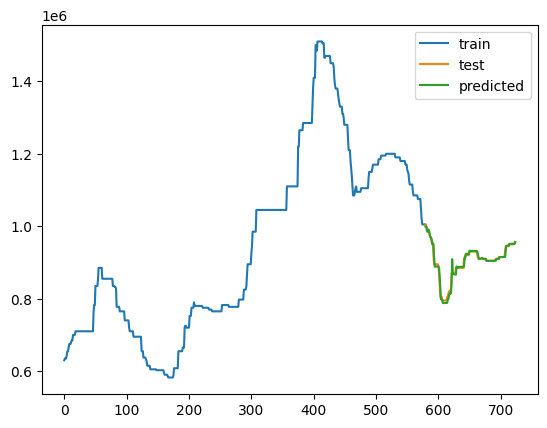

In [71]:
plt.plot(range(len(train_data)), train_data, label='train')
plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label='test')
plt.plot(range(len(train_data), len(train_data) + len(one_day_pred)),one_day_pred, label = "predicted")
plt.legend()

plt.show()

In [72]:
# Calculate model performance 
r2score = r2_score(test_data, five_day_pred)
mape = mean_absolute_percentage_error(test_data, five_day_pred)
mae = mean_absolute_error(test_data, five_day_pred)
rmse = sqrt(mean_squared_error(test_data, five_day_pred))

print('5-Day Forecast ARIMA Model')
print('Test R2: %.3f' % r2score)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)

5-Day Forecast ARIMA Model
Test R2: 0.583
Test MAE: 18977.150
Test MAPE: 0.022
Test RMSE: 30488.825


1 Day Prediction (Baseline)

In [49]:
# Final features to be used
df2 = df.copy()[["Price (CNY/T)"]]
df2["Price (CNY/T) (lag-1)"] = df2["Price (CNY/T)"].shift(1)
df2["1 Day Later Price (CNY/T)"] = df2["Price (CNY/T)"].shift(-1)

In [50]:
# Scaling of features
scaler = MinMaxScaler(feature_range=(0, 1))
scaleddf = scaler.fit_transform(df2)

In [51]:
# Splitting of explanatory features and target variable to train, validation and test sets
X, y = scaleddf[1:-1, :-1], scaleddf[1:-1, -1] # 1-day price prediction as target

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, shuffle=False)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, shuffle=True)

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [52]:
# Creation of Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [53]:
# Fitting data into model 
history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(val_X, val_y), verbose=2, shuffle=False)

Epoch 1/50


12/12 - 5s - loss: 0.3195 - val_loss: 0.2293 - 5s/epoch - 433ms/step
Epoch 2/50
12/12 - 0s - loss: 0.2072 - val_loss: 0.1433 - 75ms/epoch - 6ms/step
Epoch 3/50
12/12 - 0s - loss: 0.1343 - val_loss: 0.1158 - 76ms/epoch - 6ms/step
Epoch 4/50
12/12 - 0s - loss: 0.1036 - val_loss: 0.0925 - 74ms/epoch - 6ms/step
Epoch 5/50
12/12 - 0s - loss: 0.0777 - val_loss: 0.0667 - 75ms/epoch - 6ms/step
Epoch 6/50
12/12 - 0s - loss: 0.0533 - val_loss: 0.0414 - 74ms/epoch - 6ms/step
Epoch 7/50
12/12 - 0s - loss: 0.0318 - val_loss: 0.0150 - 79ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 0.0213 - val_loss: 0.0110 - 75ms/epoch - 6ms/step
Epoch 9/50
12/12 - 0s - loss: 0.0212 - val_loss: 0.0151 - 81ms/epoch - 7ms/step
Epoch 10/50
12/12 - 0s - loss: 0.0216 - val_loss: 0.0120 - 78ms/epoch - 7ms/step
Epoch 11/50
12/12 - 0s - loss: 0.0199 - val_loss: 0.0106 - 75ms/epoch - 6ms/step
Epoch 12/50
12/12 - 0s - loss: 0.0209 - val_loss: 0.0095 - 73ms/epoch - 6ms/step
Epoch 13/50
12/12 - 0s - loss: 0.0210 - val_loss

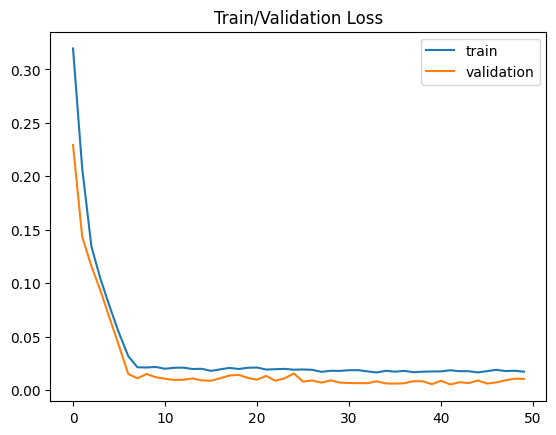

In [54]:
# Plot train/validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Train/Validation Loss")
plt.show()

In [55]:
# Predicting test set 
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = concatenate((test_X[:, :], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

7/7 [==============================] - 1s 2ms/step


In [56]:
# Calculate model performance 
r2score = r2_score(inv_y, inv_yhat)
mape = mean_absolute_percentage_error(inv_y, inv_yhat)
mae = mean_absolute_error(inv_y, inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

print('1-Day Forecast BiLSTM Model')
print('Test R2: %.3f' % r2score)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)

1-Day Forecast BiLSTM Model
Test R2: 0.991
Test MAE: 10057.685
Test MAPE: 0.010
Test RMSE: 12010.943


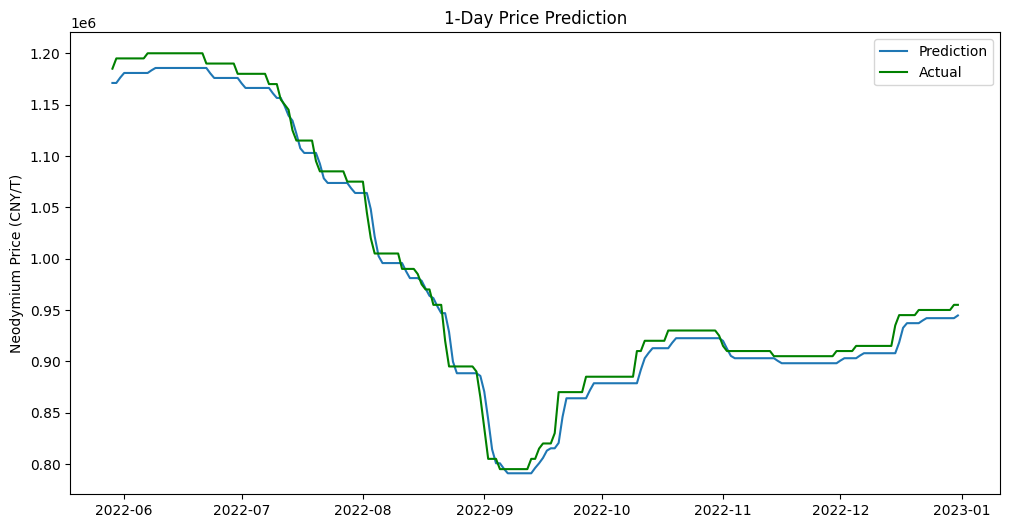

In [57]:
# Plot predicted values 
dates = df.index[-len(test_y):]
plt.figure(figsize=(12, 6))
plt.plot(dates, inv_yhat, label="Prediction")
plt.plot(dates, inv_y, label="Actual", color="green")
plt.title("1-Day Price Prediction")
plt.ylabel("Neodymium Price (CNY/T)")
plt.legend()

1-Day BiLSTM Forecast Model

In [40]:
# Final features to be used
df2 = df.copy()[cols]
for c in df2.columns:
    df2[c+" (lag-1)"] = df2[c].shift(1)
df2["1 Day Later Price (CNY/T)"] = df2["Price (CNY/T)"].shift(-1)

In [41]:
# Scaling of features
scaler = MinMaxScaler(feature_range=(0, 1))
scaleddf = scaler.fit_transform(df2)

In [42]:
# Splitting of explanatory features and target variable to train, validation and test sets
X, y = scaleddf[1:-1, :-1], scaleddf[1:-1, -1] # 1-day price prediction as target

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, shuffle=False)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, shuffle=True)

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [43]:
# Creation of Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [44]:
# Fitting data into model 
history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(val_X, val_y), verbose=2, shuffle=False)

Epoch 1/50
12/12 - 5s - loss: 0.2236 - val_loss: 0.1247 - 5s/epoch - 425ms/step
Epoch 2/50
12/12 - 0s - loss: 0.1171 - val_loss: 0.1132 - 92ms/epoch - 8ms/step
Epoch 3/50
12/12 - 0s - loss: 0.0949 - val_loss: 0.0961 - 89ms/epoch - 7ms/step
Epoch 4/50
12/12 - 0s - loss: 0.0792 - val_loss: 0.0737 - 85ms/epoch - 7ms/step
Epoch 5/50
12/12 - 0s - loss: 0.0619 - val_loss: 0.0588 - 87ms/epoch - 7ms/step
Epoch 6/50
12/12 - 0s - loss: 0.0547 - val_loss: 0.0475 - 87ms/epoch - 7ms/step
Epoch 7/50
12/12 - 0s - loss: 0.0457 - val_loss: 0.0385 - 79ms/epoch - 7ms/step
Epoch 8/50
12/12 - 0s - loss: 0.0370 - val_loss: 0.0334 - 75ms/epoch - 6ms/step
Epoch 9/50
12/12 - 0s - loss: 0.0346 - val_loss: 0.0338 - 75ms/epoch - 6ms/step
Epoch 10/50
12/12 - 0s - loss: 0.0330 - val_loss: 0.0264 - 90ms/epoch - 7ms/step
Epoch 11/50
12/12 - 0s - loss: 0.0281 - val_loss: 0.0229 - 103ms/epoch - 9ms/step
Epoch 12/50
12/12 - 0s - loss: 0.0316 - val_loss: 0.0294 - 83ms/epoch - 7ms/step
Epoch 13/50
12/12 - 0s - loss: 0.028

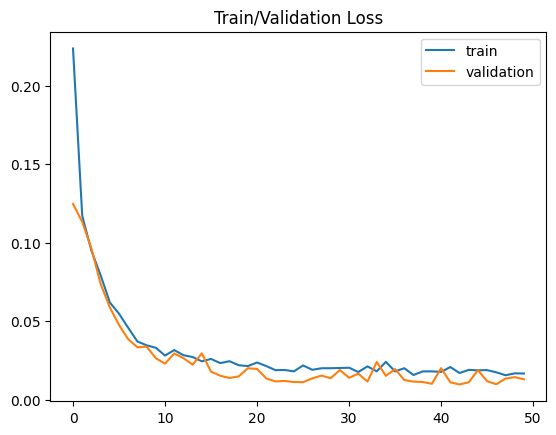

In [45]:
# Plot train/validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Train/Validation Loss")
plt.show()

In [46]:
# Predicting test set 
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = concatenate((test_X[:, :], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

7/7 [==============================] - 1s 2ms/step


In [47]:
# Calculate model performance 
r2score = r2_score(inv_y, inv_yhat)
mape = mean_absolute_percentage_error(inv_y, inv_yhat)
mae = mean_absolute_error(inv_y, inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

print('1-Day Forecast BiLSTM Model')
print('Test R2: %.3f' % r2score)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)

1-Day Forecast BiLSTM Model
Test R2: 0.976
Test MAE: 15951.768
Test MAPE: 0.017
Test RMSE: 19482.451


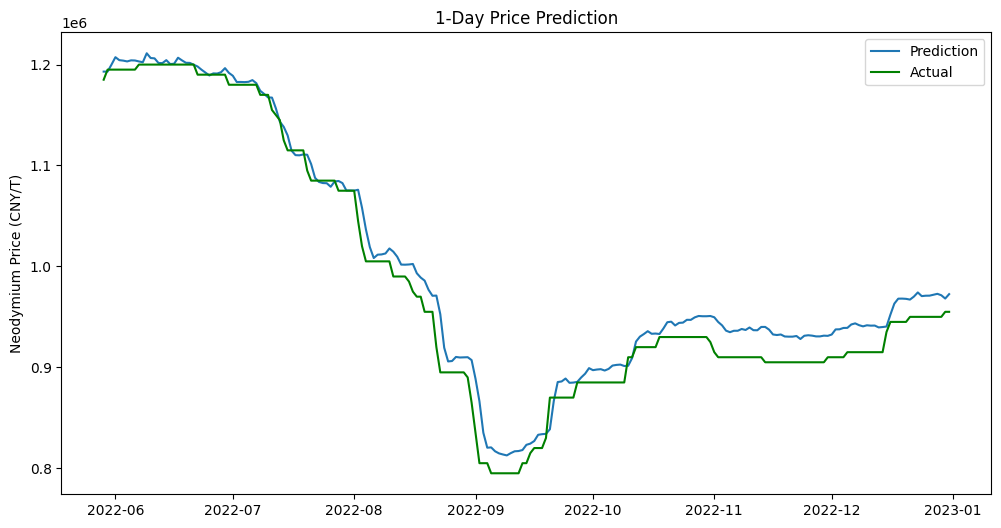

In [48]:
# Plot predicted values 
dates = df.index[-len(test_y):]
plt.figure(figsize=(12, 6))
plt.plot(dates, inv_yhat, label="Prediction")
plt.plot(dates, inv_y, label="Actual", color="green")
plt.title("1-Day Price Prediction")
plt.ylabel("Neodymium Price (CNY/T)")
plt.legend()

5-Day BiLSTM Forecast Model (Baseline)

In [47]:
# Final features to be used
df2 = df.copy()[["Price (CNY/T)"]]
df2["Price (CNY/T) (lag-1)"] = df2["Price (CNY/T)"].shift(1)
df2["5 Days Later Price (CNY/T)"] = df2["Price (CNY/T)"].shift(-5)

In [48]:
df2

Price (CNY/T)  Price (CNY/T) (lag-1)  5 Days Later Price (CNY/T)
Date                                                                        
2021-01-07       630000.0                    NaN                    655000.0
2021-01-08       635000.0               630000.0                    655000.0
2021-01-09       635000.0               635000.0                    665000.0
2021-01-10       635000.0               635000.0                    675000.0
2021-01-11       645000.0               635000.0                    675000.0
...                   ...                    ...                         ...
2022-12-27       950000.0               950000.0                         NaN
2022-12-28       950000.0               950000.0                         NaN
2022-12-29       950000.0               950000.0                         NaN
2022-12-30       955000.0               950000.0                         NaN
2022-12-31       955000.0               955000.0                         NaN

[724 rows x 3 columns]

In [49]:
# Scaling of features
scaler = MinMaxScaler(feature_range=(0, 1))
scaleddf = scaler.fit_transform(df2[["Price (CNY/T)", "Price (CNY/T) (lag-1)", "5 Days Later Price (CNY/T)"]])

In [50]:
# Splitting of explanatory features and target variable to train, validation and test sets

train_X, train_y = scaleddf[359:540, :-1], scaleddf[359:540, -1]
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, shuffle=True)
test_X, test_y = scaleddf[540:719, :-1], scaleddf[540:719, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [51]:
# Creation of Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [52]:
# Fitting data into model 
history = model.fit(train_X, train_y, epochs=150, batch_size=32, validation_data=(val_X, val_y), verbose=2, shuffle=False)

Epoch 1/150


4/4 - 5s - loss: 0.7141 - val_loss: 0.7069 - 5s/epoch - 1s/step
Epoch 2/150
4/4 - 0s - loss: 0.6586 - val_loss: 0.6489 - 51ms/epoch - 13ms/step
Epoch 3/150
4/4 - 0s - loss: 0.6013 - val_loss: 0.5904 - 57ms/epoch - 14ms/step
Epoch 4/150
4/4 - 0s - loss: 0.5464 - val_loss: 0.5305 - 56ms/epoch - 14ms/step
Epoch 5/150
4/4 - 0s - loss: 0.4855 - val_loss: 0.4684 - 57ms/epoch - 14ms/step
Epoch 6/150
4/4 - 0s - loss: 0.4271 - val_loss: 0.4029 - 55ms/epoch - 14ms/step
Epoch 7/150
4/4 - 0s - loss: 0.3590 - val_loss: 0.3330 - 58ms/epoch - 14ms/step
Epoch 8/150
4/4 - 0s - loss: 0.2874 - val_loss: 0.2579 - 55ms/epoch - 14ms/step
Epoch 9/150
4/4 - 0s - loss: 0.2143 - val_loss: 0.1765 - 54ms/epoch - 14ms/step
Epoch 10/150
4/4 - 0s - loss: 0.1352 - val_loss: 0.0923 - 56ms/epoch - 14ms/step
Epoch 11/150
4/4 - 0s - loss: 0.0679 - val_loss: 0.0522 - 56ms/epoch - 14ms/step
Epoch 12/150
4/4 - 0s - loss: 0.0658 - val_loss: 0.0742 - 59ms/epoch - 15ms/step
Epoch 13/150
4/4 - 0s - loss: 0.0901 - val_loss: 0.08

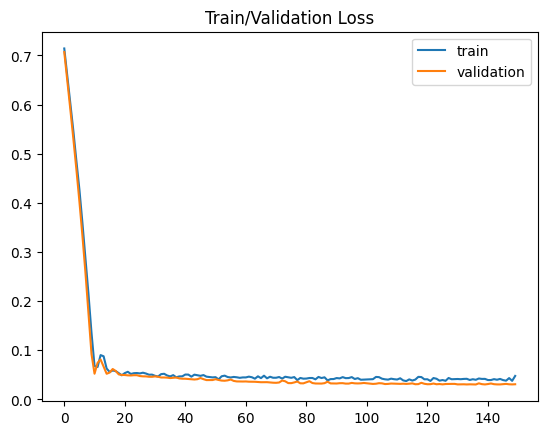

In [53]:
# Plot train/validation loss 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Train/Validation Loss")
plt.show()

In [54]:
# Predicting test set 
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = concatenate((test_X[:, :], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

6/6 [==============================] - 1s 2ms/step


In [55]:
# Calculate model performance 
r2score = r2_score(inv_y, inv_yhat)
mape = mean_absolute_percentage_error(inv_y, inv_yhat)
mae = mean_absolute_error(inv_y, inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

print('5-Days Forecast BiLSTM Model')
print('Test R2: %.3f' % r2score)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)

5-Days Forecast BiLSTM Model
Test R2: 0.657
Test MAE: 46011.381
Test MAPE: 0.050
Test RMSE: 51863.589


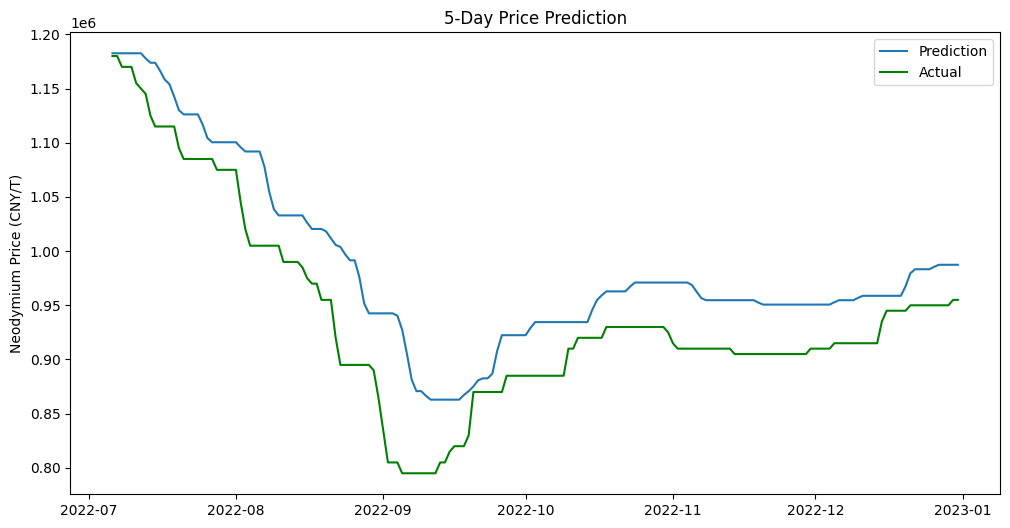

In [56]:
# Plot predicted values 
dates = df.index[-len(test_y):]
plt.figure(figsize=(12, 6))
plt.plot(dates, inv_yhat, label="Prediction")
plt.plot(dates, inv_y, label="Actual", color="green")
plt.title("5-Day Price Prediction")
plt.ylabel("Neodymium Price (CNY/T)")
plt.legend()

5-Day BiLSTM Forecast Model

In [66]:
# Final features to be used
df2 = df.copy()[cols]
for c in df2.columns:
    df2[c+" (lag-1)"] = df2[c].shift(1)
df2["5 Days Later Price (CNY/T)"] = df2["Price (CNY/T)"].shift(-5)

In [67]:
# Scaling of features
scaler = MinMaxScaler(feature_range=(0, 1))
scaleddf = scaler.fit_transform(df2)

In [68]:
# Splitting of explanatory features and target variable to train, validation and test sets
X, y = scaleddf[1:-5, :-1], scaleddf[1:-5, -1] # 5-day price prediction as target

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, shuffle=False)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, shuffle=True)

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [69]:
# Creation of Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [70]:
# Fitting data into model 
history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(val_X, val_y), verbose=2, shuffle=False)

Epoch 1/50


11/11 - 6s - loss: 0.2307 - val_loss: 0.1004 - 6s/epoch - 501ms/step
Epoch 2/50
11/11 - 0s - loss: 0.1216 - val_loss: 0.1099 - 76ms/epoch - 7ms/step
Epoch 3/50
11/11 - 0s - loss: 0.1021 - val_loss: 0.0724 - 72ms/epoch - 7ms/step
Epoch 4/50
11/11 - 0s - loss: 0.0855 - val_loss: 0.0605 - 85ms/epoch - 8ms/step
Epoch 5/50
11/11 - 0s - loss: 0.0631 - val_loss: 0.0524 - 75ms/epoch - 7ms/step
Epoch 6/50
11/11 - 0s - loss: 0.0574 - val_loss: 0.0475 - 74ms/epoch - 7ms/step
Epoch 7/50
11/11 - 0s - loss: 0.0465 - val_loss: 0.0466 - 74ms/epoch - 7ms/step
Epoch 8/50
11/11 - 0s - loss: 0.0443 - val_loss: 0.0423 - 81ms/epoch - 7ms/step
Epoch 9/50
11/11 - 0s - loss: 0.0434 - val_loss: 0.0388 - 79ms/epoch - 7ms/step
Epoch 10/50
11/11 - 0s - loss: 0.0400 - val_loss: 0.0359 - 78ms/epoch - 7ms/step
Epoch 11/50
11/11 - 0s - loss: 0.0407 - val_loss: 0.0347 - 79ms/epoch - 7ms/step
Epoch 12/50
11/11 - 0s - loss: 0.0345 - val_loss: 0.0324 - 81ms/epoch - 7ms/step
Epoch 13/50
11/11 - 0s - loss: 0.0401 - val_loss

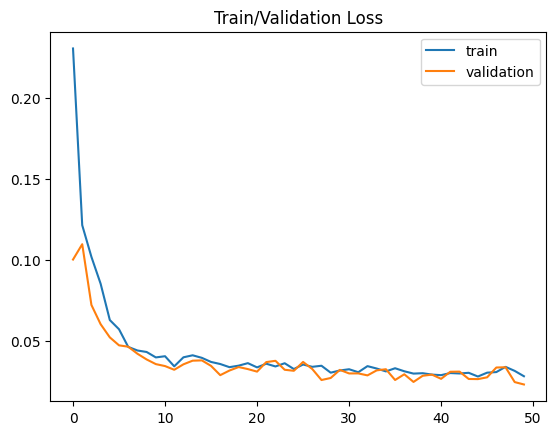

In [71]:
# Plot train/validation loss 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Train/Validation Loss")
plt.show()

In [72]:
# Predicting test set 
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = concatenate((test_X[:, :], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

7/7 [==============================] - 1s 2ms/step


In [73]:
# Calculate model performance 
r2score = r2_score(inv_y, inv_yhat)
mape = mean_absolute_percentage_error(inv_y, inv_yhat)
mae = mean_absolute_error(inv_y, inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

print('5-Days Forecast BiLSTM Model')
print('Test R2: %.3f' % r2score)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)

5-Days Forecast BiLSTM Model
Test R2: 0.932
Test MAE: 27084.768
Test MAPE: 0.028
Test RMSE: 32593.606


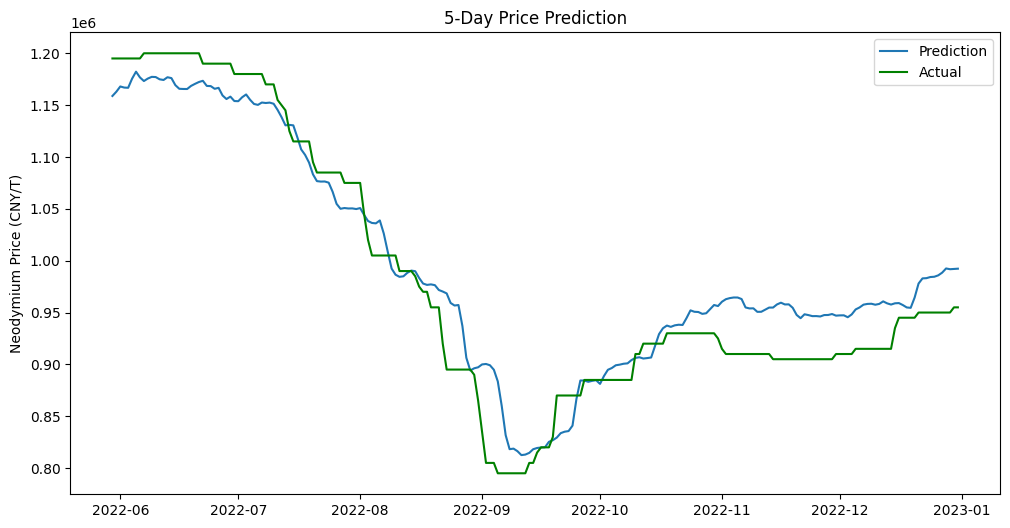

In [74]:
# Plot predicted values 
dates = df.index[-len(test_y):]
plt.figure(figsize=(12, 6))
plt.plot(dates, inv_yhat, label="Prediction")
plt.plot(dates, inv_y, label="Actual", color="green")
plt.title("5-Day Price Prediction")
plt.ylabel("Neodymium Price (CNY/T)")
plt.legend()

5 Days Price Direction

In [278]:
# Final features to be used
df3 = df.copy()[cols]
for c in df3.columns:
    df3[c+" (lag-1)"] = df3[c].shift(1)
df3["5 Days Later Price (CNY/T)"] = df3["Price (CNY/T)"].shift(-5)

df3["5 Days Later Price Change Direction"] = df["Price (CNY/T)"].shift(-5) - df["Price (CNY/T)"]
df3["5 Days Later Price Change Direction"] = list(map(lambda x: 1 if x > 0 else (-1 if x < 0 else 0), df3["5 Days Later Price Change Direction"].tolist()))

In [279]:
# Scaling of features
scaler = MinMaxScaler(feature_range=(0, 1))
scaleddf = scaler.fit_transform(df3)

In [280]:
# Splitting of explanatory features and target variable to train, validation and test sets
X, y = np.array(df3.iloc[5:-5, :-1]), np.array(df3.iloc[5:-5, -1]) # 5-day price prediction as target

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, shuffle=False)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, shuffle=True)

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [281]:
# One-hot encoding of target features into 0, 1, -1 classes
train_y = to_categorical(train_y, 3)
val_y = to_categorical(val_y, 3)
test_y = to_categorical(test_y, 3)

In [282]:
# Creation of Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(80, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [283]:
# Fitting data into model 
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(val_X, val_y), verbose=2, shuffle=False)

Epoch 1/50


5/5 - 4s - loss: 2615249.5000 - accuracy: 0.3037 - val_loss: 877616.1875 - val_accuracy: 0.2667 - 4s/epoch - 754ms/step
Epoch 2/50
5/5 - 0s - loss: 1681425.6250 - accuracy: 0.3266 - val_loss: 566960.1250 - val_accuracy: 0.4400 - 80ms/epoch - 16ms/step
Epoch 3/50
5/5 - 0s - loss: 1573354.5000 - accuracy: 0.3352 - val_loss: 643400.5625 - val_accuracy: 0.4400 - 80ms/epoch - 16ms/step
Epoch 4/50
5/5 - 0s - loss: 1500981.8750 - accuracy: 0.3496 - val_loss: 645116.5000 - val_accuracy: 0.4467 - 104ms/epoch - 21ms/step
Epoch 5/50
5/5 - 0s - loss: 1094732.3750 - accuracy: 0.3639 - val_loss: 592104.9375 - val_accuracy: 0.4067 - 80ms/epoch - 16ms/step
Epoch 6/50
5/5 - 0s - loss: 1082412.8750 - accuracy: 0.4011 - val_loss: 531143.7500 - val_accuracy: 0.4200 - 72ms/epoch - 14ms/step
Epoch 7/50
5/5 - 0s - loss: 1256574.8750 - accuracy: 0.3381 - val_loss: 463721.0625 - val_accuracy: 0.4200 - 81ms/epoch - 16ms/step
Epoch 8/50
5/5 - 0s - loss: 1115871.2500 - accuracy: 0.3496 - val_loss: 391424.0938 - v

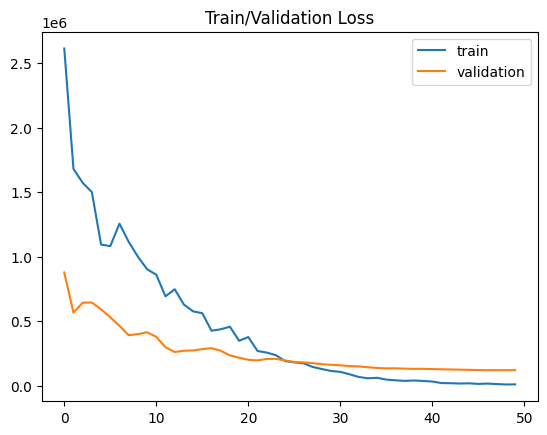

In [284]:
# Plot train/validation loss 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Train/Validation Loss")
plt.show()

In [285]:
yhat = model.predict(test_X)
yhat_cat = list(map(lambda x: 0 if max(x)==x[0] else (1 if max(x)==x[1] else -1), yhat))
y_cat = list(map(lambda x: 0 if max(x)==x[0] else (1 if max(x)==x[1] else -1), test_y))

7/7 [==============================] - 0s 2ms/step


In [286]:
# Accuracy score
accuracy_score(y_cat, yhat_cat)

0.3488372093023256

In [287]:
# Confusion Matrix
cm = confusion_matrix(y_cat, yhat_cat)
cm_df = pd.DataFrame(cm,
                     index = ['Actual Decrease','Actual No Change','Actual Increase'], 
                     columns = ['Predict Decrease','Predict No Change','Predict Increase'])
cm_df

Predict Decrease  Predict No Change  Predict Increase
Actual Decrease                 19                  3                58
Actual No Change                12                  3                59
Actual Increase                  6                  2                53

In [288]:
# Precision, recall, F1-score and support
print(classification_report(y_cat, yhat_cat))

              precision    recall  f1-score   support

          -1       0.51      0.24      0.32        80
           0       0.38      0.04      0.07        74
           1       0.31      0.87      0.46        61

    accuracy                           0.35       215
   macro avg       0.40      0.38      0.29       215
weighted avg       0.41      0.35      0.28       215



In [ ]:
print(df.index[0], "- to -", df.index[174])
print(df.index[175], "- to -", df.index[358])
print(df.index[359], "- to -", df.index[539])
print(df.index[540], "- to -", df.index[723])

2021-01-07 00:00:00 - to - 2021-06-30 00:00:00
2021-07-01 00:00:00 - to - 2021-12-31 00:00:00
2022-01-01 00:00:00 - to - 2022-06-30 00:00:00
2022-07-01 00:00:00 - to - 2022-12-22 00:00:00


### Prediction Period: Jul 2021 to Dec 2021

1-Day ARIMA Forecast Model

In [ ]:
one_day_pred = pd.Series([])
y = df['Price (CNY/T)']
test_data = y[175 : 359]

for i in np.arange(175, 359, 1):

    training_window = y[i-50 : i]

    arima_model = auto_arima(training_window)
    arima_model.summary()

    one_day_pred = one_day_pred.append(arima_model.predict(n_periods = 1))

C:\Users\brian\AppData\Local\Temp\ipykernel_11392\1902877538.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  one_day_pred = pd.Series([])


C:\Users\brian\AppData\Local\Temp\ipykernel_11392\1902877538.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  one_day_pred = one_day_pred.append(arima_model.predict(n_periods = 1))
C:\Users\brian\AppData\Local\Temp\ipykernel_11392\1902877538.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  one_day_pred = one_day_pred.append(arima_model.predict(n_periods = 1))
C:\Users\brian\AppData\Local\Temp\ipykernel_11392\1902877538.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  one_day_pred = one_day_pred.append(arima_model.predict(n_periods = 1))
C:\Users\brian\AppData\Local\Temp\ipykernel_11392\1902877538.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. 

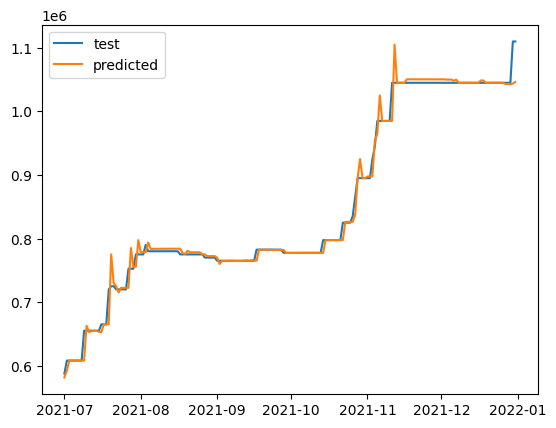

In [ ]:
plt.plot(test_data.index, test_data, label='test')
plt.plot(test_data.index, one_day_pred, label = "predicted")
plt.legend()

plt.show()

In [ ]:
# Calculate model performance 
r2score = r2_score(test_data, one_day_pred,)
mape = mean_absolute_percentage_error(test_data, one_day_pred,)
mae = mean_absolute_error(test_data, one_day_pred,)
rmse = sqrt(mean_squared_error(test_data, one_day_pred,))

print('1-Day Forecast ARIMA Model')
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)

1-Day Forecast ARIMA Model
Test MAE: 5936.602
Test MAPE: 0.007
Test RMSE: 13675.737


5-Day ARIMA Forecast Model

In [ ]:
five_day_pred = pd.Series([])
y = df['Price (CNY/T)']
test_data = y[175 : 359]

for i in np.arange(175, 359, 1):

    training_window = y[i-18 : i-4]

    arima_model = auto_arima(training_window)
    arima_model.summary()

    five_day_pred = five_day_pred.append(arima_model.predict(n_periods = 5)[-1:])

C:\Users\brian\AppData\Local\Temp\ipykernel_11392\2380832196.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  five_day_pred = pd.Series([])
C:\Users\brian\AppData\Local\Temp\ipykernel_11392\2380832196.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  five_day_pred = five_day_pred.append(arima_model.predict(n_periods = 5)[-1:])
C:\Users\brian\AppData\Local\Temp\ipykernel_11392\2380832196.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  five_day_pred = five_day_pred.append(arima_model.predict(n_periods = 5)[-1:])
C:\Users\brian\AppData\Local\Temp\ipykernel_11392\2380832196.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. U

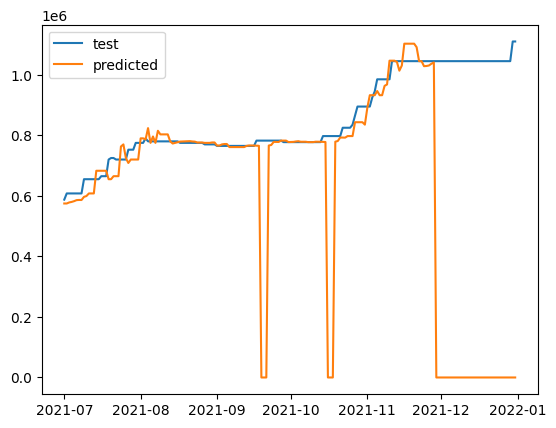

In [ ]:
plt.plot(test_data.index, test_data, label='test')
plt.plot(test_data.index, five_day_pred, label = "predicted")
plt.legend()

plt.show()

In [ ]:
# Calculate model performance 
mape = mean_absolute_percentage_error(test_data, five_day_pred)
mae = mean_absolute_error(test_data, five_day_pred)
rmse = sqrt(mean_squared_error(test_data, five_day_pred))

print('5-Day Forecast ARIMA Model')
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)

5-Day Forecast ARIMA Model
Test MAE: 229473.018
Test MAPE: 0.232
Test RMSE: 467277.894


1-Day BiLSTM Forecast Model

In [ ]:
# Final features to be used
df2 = df.copy()[cols]
for c in df2.columns:
    df2[c+" (lag-1)"] = df2[c].shift(1)
df2["1 Day Later Price (CNY/T)"] = df2["Price (CNY/T)"].shift(-1)

In [ ]:
# Scaling of features
scaler = MinMaxScaler(feature_range=(0, 1))
scaleddf = scaler.fit_transform(df2)

In [ ]:
# Splitting of explanatory features and target variable to train, validation and test sets

train_X, train_y = scaleddf[1:175, :-1], scaleddf[1:175, -1]
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, shuffle=True)
test_X, test_y = scaleddf[175:359, :-1], scaleddf[175:359, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [ ]:
# Creation of Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [ ]:
# Fitting data into model 
history = model.fit(train_X, train_y, epochs=150, batch_size=32, validation_data=(val_X, val_y), verbose=2, shuffle=False)

Epoch 1/150


4/4 - 4s - loss: 0.1009 - val_loss: 0.0834 - 4s/epoch - 951ms/step
Epoch 2/150
4/4 - 0s - loss: 0.0619 - val_loss: 0.0689 - 37ms/epoch - 9ms/step
Epoch 3/150
4/4 - 0s - loss: 0.0634 - val_loss: 0.0639 - 37ms/epoch - 9ms/step
Epoch 4/150
4/4 - 0s - loss: 0.0558 - val_loss: 0.0594 - 35ms/epoch - 9ms/step
Epoch 5/150
4/4 - 0s - loss: 0.0513 - val_loss: 0.0595 - 37ms/epoch - 9ms/step
Epoch 6/150
4/4 - 0s - loss: 0.0490 - val_loss: 0.0542 - 39ms/epoch - 10ms/step
Epoch 7/150
4/4 - 0s - loss: 0.0433 - val_loss: 0.0470 - 39ms/epoch - 10ms/step
Epoch 8/150
4/4 - 0s - loss: 0.0390 - val_loss: 0.0409 - 37ms/epoch - 9ms/step
Epoch 9/150
4/4 - 0s - loss: 0.0374 - val_loss: 0.0375 - 38ms/epoch - 10ms/step
Epoch 10/150
4/4 - 0s - loss: 0.0367 - val_loss: 0.0362 - 40ms/epoch - 10ms/step
Epoch 11/150
4/4 - 0s - loss: 0.0330 - val_loss: 0.0394 - 51ms/epoch - 13ms/step
Epoch 12/150
4/4 - 0s - loss: 0.0343 - val_loss: 0.0319 - 57ms/epoch - 14ms/step
Epoch 13/150
4/4 - 0s - loss: 0.0312 - val_loss: 0.0285

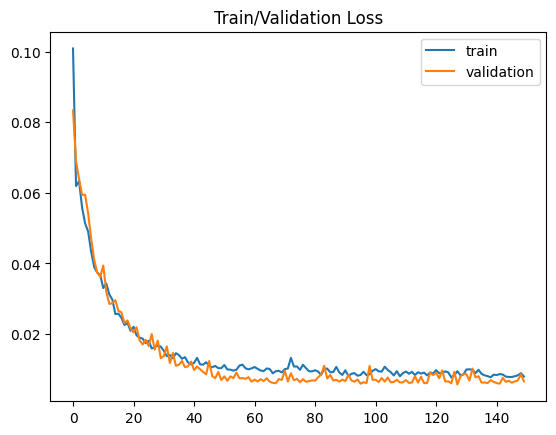

In [ ]:
# Plot train/validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Train/Validation Loss")
plt.show()

In [ ]:
# Predicting test set 
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = concatenate((test_X[:, :], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

6/6 [==============================] - 1s 2ms/step


In [ ]:
# Calculate model performance 
r2score = r2_score(inv_y, inv_yhat)
mape = mean_absolute_percentage_error(inv_y, inv_yhat)
mae = mean_absolute_error(inv_y, inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

print('1-Day Forecast BiLSTM Model')
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)

1-Day Forecast BiLSTM Model
Test MAE: 30539.559
Test MAPE: 0.034
Test RMSE: 38929.724


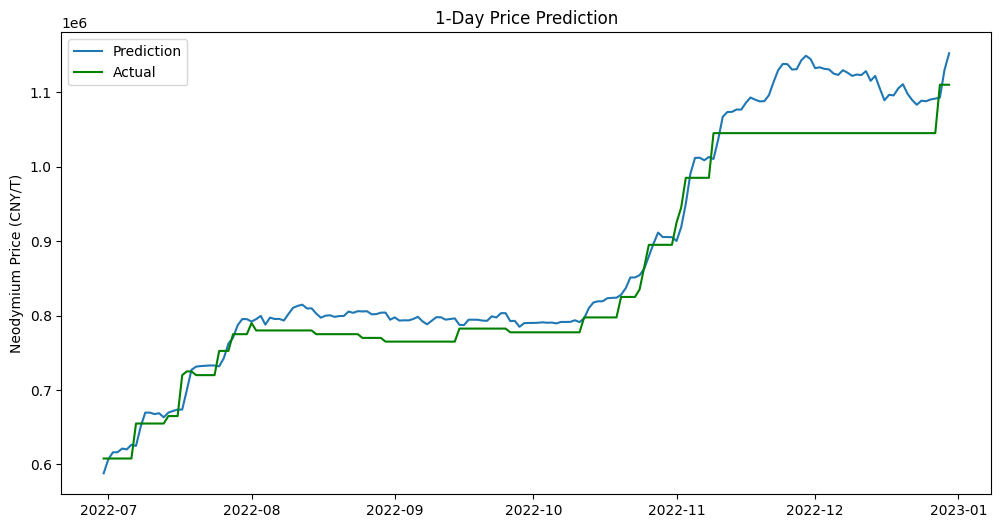

In [ ]:
# Plot predicted values 
dates = df.index[-len(test_y):]
plt.figure(figsize=(12, 6))
plt.plot(dates, inv_yhat, label="Prediction")
plt.plot(dates, inv_y, label="Actual", color="green")
plt.title("1-Day Price Prediction")
plt.ylabel("Neodymium Price (CNY/T)")
plt.legend()

5-Day BiLSTM Forecast Model (Baseline)

In [ ]:
# Final features to be used
df2 = df.copy()[cols]
for c in df2.columns:
    df2[c+" (lag-1)"] = df2[c].shift(1)
df2["5 Days Later Price (CNY/T)"] = df2["Price (CNY/T)"].shift(-5)

In [ ]:
# Scaling of features
scaler = MinMaxScaler(feature_range=(0, 1))
scaleddf = scaler.fit_transform(df2[["Price (CNY/T)", "Price (CNY/T) (lag-1)", "5 Days Later Price (CNY/T)"]])

In [ ]:
# Splitting of explanatory features and target variable to train, validation and test sets

train_X, train_y = scaleddf[1:175, :-1], scaleddf[1:175, -1]
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, shuffle=True)
test_X, test_y = scaleddf[175:359, :-1], scaleddf[175:359, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [ ]:
# Creation of Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [ ]:
# Fitting data into model 
history = model.fit(train_X, train_y, epochs=150, batch_size=32, validation_data=(val_X, val_y), verbose=2, shuffle=False)

Epoch 1/150


4/4 - 4s - loss: 0.1229 - val_loss: 0.1023 - 4s/epoch - 1s/step
Epoch 2/150
4/4 - 0s - loss: 0.1002 - val_loss: 0.0869 - 47ms/epoch - 12ms/step
Epoch 3/150
4/4 - 0s - loss: 0.0837 - val_loss: 0.0740 - 49ms/epoch - 12ms/step
Epoch 4/150
4/4 - 0s - loss: 0.0685 - val_loss: 0.0623 - 42ms/epoch - 10ms/step
Epoch 5/150
4/4 - 0s - loss: 0.0574 - val_loss: 0.0581 - 52ms/epoch - 13ms/step
Epoch 6/150
4/4 - 0s - loss: 0.0569 - val_loss: 0.0607 - 56ms/epoch - 14ms/step
Epoch 7/150
4/4 - 0s - loss: 0.0589 - val_loss: 0.0586 - 44ms/epoch - 11ms/step
Epoch 8/150
4/4 - 0s - loss: 0.0555 - val_loss: 0.0527 - 39ms/epoch - 10ms/step
Epoch 9/150
4/4 - 0s - loss: 0.0496 - val_loss: 0.0473 - 46ms/epoch - 12ms/step
Epoch 10/150
4/4 - 0s - loss: 0.0471 - val_loss: 0.0470 - 37ms/epoch - 9ms/step
Epoch 11/150
4/4 - 0s - loss: 0.0460 - val_loss: 0.0448 - 40ms/epoch - 10ms/step
Epoch 12/150
4/4 - 0s - loss: 0.0425 - val_loss: 0.0402 - 40ms/epoch - 10ms/step
Epoch 13/150
4/4 - 0s - loss: 0.0391 - val_loss: 0.037

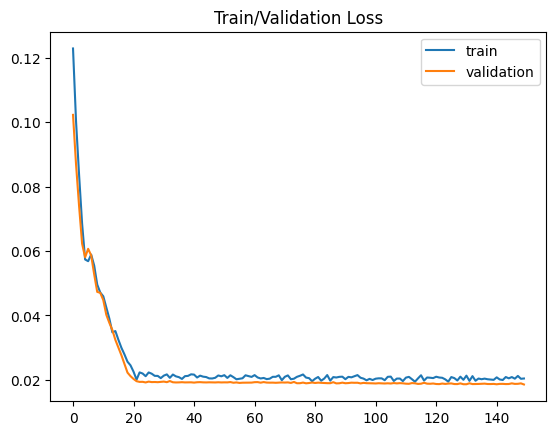

In [ ]:
# Plot train/validation loss 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Train/Validation Loss")
plt.show()

In [ ]:
# Predicting test set 
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = concatenate((test_X[:, :], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

6/6 [==============================] - 1s 2ms/step


In [ ]:
# Calculate model performance 
mape = mean_absolute_percentage_error(inv_y, inv_yhat)
mae = mean_absolute_error(inv_y, inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

print('5-Days Forecast BiLSTM Model')
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)

5-Days Forecast BiLSTM Model
Test MAE: 20960.134
Test MAPE: 0.024
Test RMSE: 32097.427


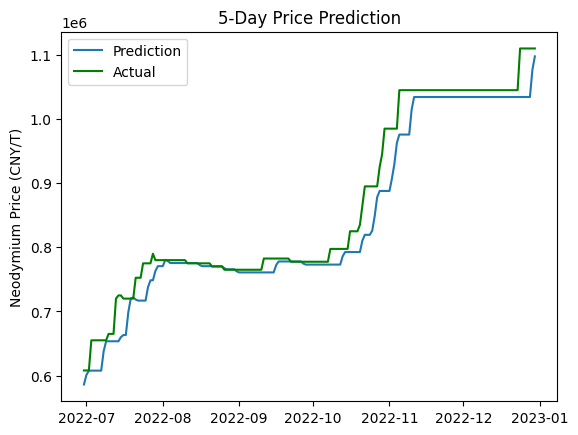

In [ ]:
# Plot predicted values 
dates = df.index[-len(test_y):]
#plt.figure(figsize=(12, 6))
plt.plot(dates, inv_yhat, label="Prediction")
plt.plot(dates, inv_y, label="Actual", color="green")
plt.title("5-Day Price Prediction")
plt.ylabel("Neodymium Price (CNY/T)")
plt.legend()

5-Day BiLSTM Forecast Model

In [ ]:
# Final features to be used
df2 = df.copy()[cols]
for c in df2.columns:
    df2[c+" (lag-1)"] = df2[c].shift(1)
df2["5 Days Later Price (CNY/T)"] = df2["Price (CNY/T)"].shift(-5)

In [ ]:
# Scaling of features
scaler = MinMaxScaler(feature_range=(0, 1))
scaleddf = scaler.fit_transform(df2)

In [ ]:
# Splitting of explanatory features and target variable to train, validation and test sets

train_X, train_y = scaleddf[1:175, :-1], scaleddf[1:175, -1]
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, shuffle=True)
test_X, test_y = scaleddf[175:359, :-1], scaleddf[175:359, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [ ]:
# Creation of Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [ ]:
# Fitting data into model 
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(val_X, val_y), verbose=2, shuffle=False)

Epoch 1/100


4/4 - 4s - loss: 0.1090 - val_loss: 0.0840 - 4s/epoch - 1s/step
Epoch 2/100
4/4 - 0s - loss: 0.0814 - val_loss: 0.0585 - 47ms/epoch - 12ms/step
Epoch 3/100
4/4 - 0s - loss: 0.0710 - val_loss: 0.0566 - 31ms/epoch - 8ms/step
Epoch 4/100
4/4 - 0s - loss: 0.0619 - val_loss: 0.0435 - 31ms/epoch - 8ms/step
Epoch 5/100
4/4 - 0s - loss: 0.0517 - val_loss: 0.0415 - 32ms/epoch - 8ms/step
Epoch 6/100
4/4 - 0s - loss: 0.0467 - val_loss: 0.0376 - 31ms/epoch - 8ms/step
Epoch 7/100
4/4 - 0s - loss: 0.0407 - val_loss: 0.0305 - 47ms/epoch - 12ms/step
Epoch 8/100
4/4 - 0s - loss: 0.0338 - val_loss: 0.0264 - 47ms/epoch - 12ms/step
Epoch 9/100
4/4 - 0s - loss: 0.0284 - val_loss: 0.0245 - 42ms/epoch - 11ms/step
Epoch 10/100
4/4 - 0s - loss: 0.0279 - val_loss: 0.0250 - 49ms/epoch - 12ms/step
Epoch 11/100
4/4 - 0s - loss: 0.0253 - val_loss: 0.0256 - 48ms/epoch - 12ms/step
Epoch 12/100
4/4 - 0s - loss: 0.0264 - val_loss: 0.0250 - 48ms/epoch - 12ms/step
Epoch 13/100
4/4 - 0s - loss: 0.0259 - val_loss: 0.0244 -

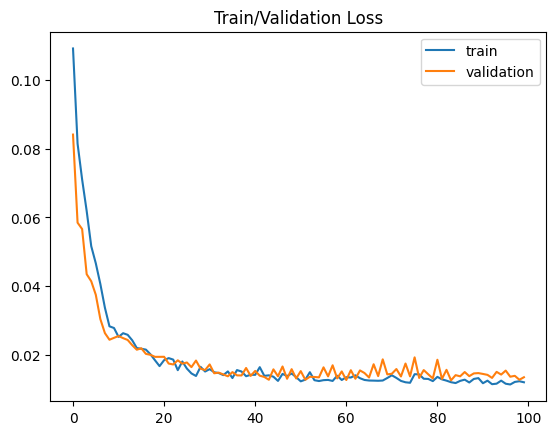

In [ ]:
# Plot train/validation loss 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Train/Validation Loss")
plt.show()

In [ ]:
# Predicting test set 
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = concatenate((test_X[:, :], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

6/6 [==============================] - 1s 2ms/step


In [ ]:
# Calculate model performance 
mape = mean_absolute_percentage_error(inv_y, inv_yhat)
mae = mean_absolute_error(inv_y, inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

print('5-Days Forecast BiLSTM Model')
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)

5-Days Forecast BiLSTM Model
Test MAE: 57268.696
Test MAPE: 0.065
Test RMSE: 74854.001


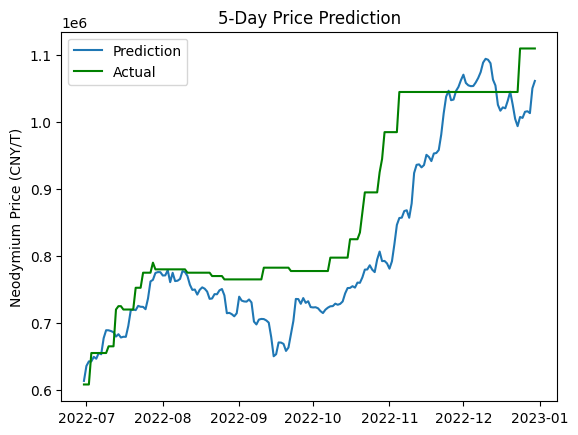

In [ ]:
# Plot predicted values 
dates = df.index[-len(test_y):]
#plt.figure(figsize=(12, 6))
plt.plot(dates, inv_yhat, label="Prediction")
plt.plot(dates, inv_y, label="Actual", color="green")
plt.title("5-Day Price Prediction")
plt.ylabel("Neodymium Price (CNY/T)")
plt.legend()

### Prediction Period: Jan 2022 to Jun 2022

5-Day ARIMA Forecast Model

In [105]:
five_day_pred = pd.Series([])
y = df['Price (CNY/T)']
test_data = y[359 : 539]

for i in np.arange(359, 539, 1):

    training_window = y[i-18 : i-4]

    arima_model = auto_arima(training_window)
    arima_model.summary()

    five_day_pred = five_day_pred.append(arima_model.predict(n_periods = 5)[-1:])

C:\Users\brian\AppData\Local\Temp\ipykernel_11392\2527276305.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  five_day_pred = pd.Series([])
c:\Users\brian\AppData\Local\Programs\Python\Python38\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\Users\brian\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
c:\Users\brian\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\stats\stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resid

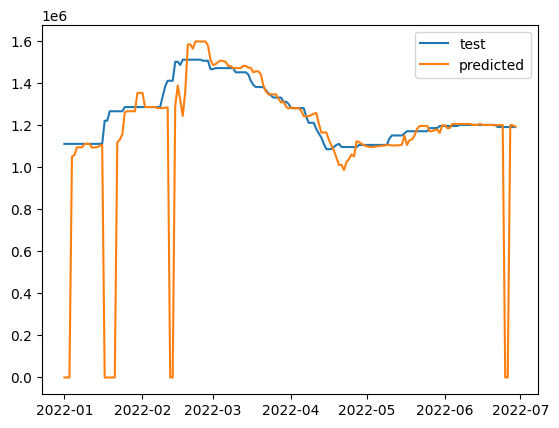

In [106]:
plt.plot(test_data.index, test_data, label='test')
plt.plot(test_data.index, five_day_pred, label = "predicted")
plt.legend()

plt.show()

In [107]:
# Calculate model performance 
mape = mean_absolute_percentage_error(test_data, five_day_pred)
mae = mean_absolute_error(test_data, five_day_pred)
rmse = sqrt(mean_squared_error(test_data, five_day_pred))

print('5-Day Forecast ARIMA Model')
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)

5-Day Forecast ARIMA Model
Test MAE: 113335.568
Test MAPE: 0.091
Test RMSE: 322801.381


5-Day BiLSTM Forecast Model (Baseline)

In [108]:
# Final features to be used
df2 = df.copy()[cols]
for c in df2.columns:
    df2[c+" (lag-1)"] = df2[c].shift(1)
df2["5 Days Later Price (CNY/T)"] = df2["Price (CNY/T)"].shift(-5)

In [109]:
# Scaling of features
scaler = MinMaxScaler(feature_range=(0, 1))
scaleddf = scaler.fit_transform(df2[["Price (CNY/T)", "Price (CNY/T) (lag-1)", "5 Days Later Price (CNY/T)"]])

In [110]:
# Splitting of explanatory features and target variable to train, validation and test sets

train_X, train_y = scaleddf[175:359, :-1], scaleddf[175:359, -1]
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, shuffle=True)
test_X, test_y = scaleddf[359:539, :-1], scaleddf[359:539, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [111]:
# Creation of Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [112]:
# Fitting data into model 
history = model.fit(train_X, train_y, epochs=150, batch_size=32, validation_data=(val_X, val_y), verbose=2, shuffle=False)

Epoch 1/150


4/4 - 4s - loss: 0.2745 - val_loss: 0.3189 - 4s/epoch - 927ms/step
Epoch 2/150
4/4 - 0s - loss: 0.2388 - val_loss: 0.2803 - 43ms/epoch - 11ms/step
Epoch 3/150
4/4 - 0s - loss: 0.2036 - val_loss: 0.2410 - 42ms/epoch - 11ms/step
Epoch 4/150
4/4 - 0s - loss: 0.1665 - val_loss: 0.2007 - 41ms/epoch - 10ms/step
Epoch 5/150
4/4 - 0s - loss: 0.1328 - val_loss: 0.1591 - 42ms/epoch - 10ms/step
Epoch 6/150
4/4 - 0s - loss: 0.0967 - val_loss: 0.1171 - 42ms/epoch - 10ms/step
Epoch 7/150
4/4 - 0s - loss: 0.0715 - val_loss: 0.0973 - 42ms/epoch - 10ms/step
Epoch 8/150
4/4 - 0s - loss: 0.0728 - val_loss: 0.0875 - 45ms/epoch - 11ms/step
Epoch 9/150
4/4 - 0s - loss: 0.0735 - val_loss: 0.0815 - 43ms/epoch - 11ms/step
Epoch 10/150
4/4 - 0s - loss: 0.0729 - val_loss: 0.0776 - 54ms/epoch - 13ms/step
Epoch 11/150
4/4 - 0s - loss: 0.0716 - val_loss: 0.0751 - 43ms/epoch - 11ms/step
Epoch 12/150
4/4 - 0s - loss: 0.0680 - val_loss: 0.0735 - 43ms/epoch - 11ms/step
Epoch 13/150
4/4 - 0s - loss: 0.0638 - val_loss: 0

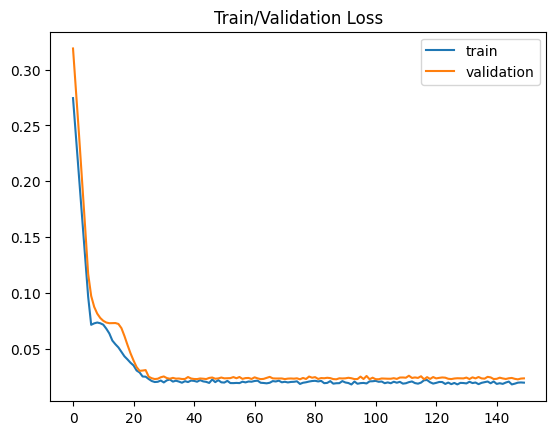

In [113]:
# Plot train/validation loss 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Train/Validation Loss")
plt.show()

In [114]:
# Predicting test set 
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = concatenate((test_X[:, :], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

6/6 [==============================] - 1s 0s/step


In [115]:
# Calculate model performance 
mape = mean_absolute_percentage_error(inv_y, inv_yhat)
mae = mean_absolute_error(inv_y, inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

print('5-Days Forecast BiLSTM Model')
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)

5-Days Forecast BiLSTM Model
Test MAE: 45490.130
Test MAPE: 0.035
Test RMSE: 61556.452


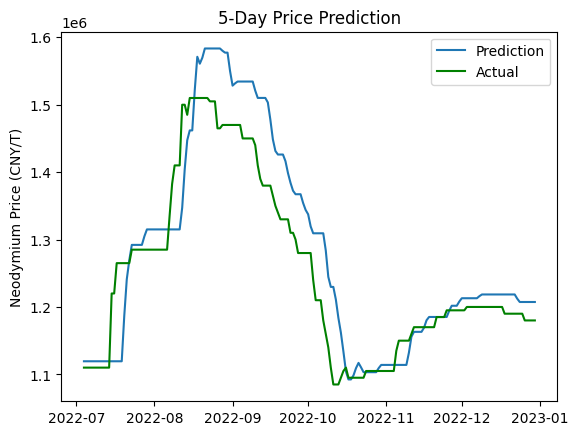

In [116]:
# Plot predicted values 
dates = df.index[-len(test_y):]
#plt.figure(figsize=(12, 6))
plt.plot(dates, inv_yhat, label="Prediction")
plt.plot(dates, inv_y, label="Actual", color="green")
plt.title("5-Day Price Prediction")
plt.ylabel("Neodymium Price (CNY/T)")
plt.legend()

5-Day BiLSTM Forecast Model

In [117]:
# Final features to be used
df2 = df.copy()[cols]
for c in df2.columns:
    df2[c+" (lag-1)"] = df2[c].shift(1)
df2["5 Days Later Price (CNY/T)"] = df2["Price (CNY/T)"].shift(-5)

In [118]:
# Scaling of features
scaler = MinMaxScaler(feature_range=(0, 1))
scaleddf = scaler.fit_transform(df2)

In [119]:
# Splitting of explanatory features and target variable to train, validation and test sets

train_X, train_y = scaleddf[175:359, :-1], scaleddf[175:359, -1]
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, shuffle=True)
test_X, test_y = scaleddf[359:539, :-1], scaleddf[359:539, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [120]:
# Creation of Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [121]:
# Fitting data into model 
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(val_X, val_y), verbose=2, shuffle=False)

Epoch 1/100


4/4 - 4s - loss: 0.2988 - val_loss: 0.1537 - 4s/epoch - 967ms/step
Epoch 2/100
4/4 - 0s - loss: 0.1152 - val_loss: 0.0714 - 46ms/epoch - 11ms/step
Epoch 3/100
4/4 - 0s - loss: 0.0934 - val_loss: 0.1190 - 47ms/epoch - 12ms/step
Epoch 4/100
4/4 - 0s - loss: 0.1103 - val_loss: 0.0906 - 48ms/epoch - 12ms/step
Epoch 5/100
4/4 - 0s - loss: 0.0715 - val_loss: 0.0645 - 47ms/epoch - 12ms/step
Epoch 6/100
4/4 - 0s - loss: 0.0687 - val_loss: 0.0707 - 46ms/epoch - 12ms/step
Epoch 7/100
4/4 - 0s - loss: 0.0735 - val_loss: 0.0628 - 45ms/epoch - 11ms/step
Epoch 8/100
4/4 - 0s - loss: 0.0620 - val_loss: 0.0575 - 46ms/epoch - 11ms/step
Epoch 9/100
4/4 - 0s - loss: 0.0587 - val_loss: 0.0613 - 52ms/epoch - 13ms/step
Epoch 10/100
4/4 - 0s - loss: 0.0544 - val_loss: 0.0516 - 44ms/epoch - 11ms/step
Epoch 11/100
4/4 - 0s - loss: 0.0492 - val_loss: 0.0475 - 49ms/epoch - 12ms/step
Epoch 12/100
4/4 - 0s - loss: 0.0475 - val_loss: 0.0442 - 49ms/epoch - 12ms/step
Epoch 13/100
4/4 - 0s - loss: 0.0491 - val_loss: 0

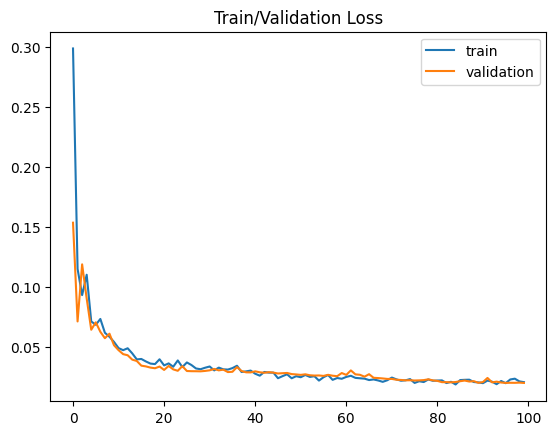

In [122]:
# Plot train/validation loss 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Train/Validation Loss")
plt.show()

In [123]:
# Predicting test set 
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = concatenate((test_X[:, :], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

6/6 [==============================] - 1s 3ms/step


In [124]:
# Calculate model performance 
mape = mean_absolute_percentage_error(inv_y, inv_yhat)
mae = mean_absolute_error(inv_y, inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

print('5-Days Forecast BiLSTM Model')
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)

5-Days Forecast BiLSTM Model
Test MAE: 53047.953
Test MAPE: 0.042
Test RMSE: 68206.433


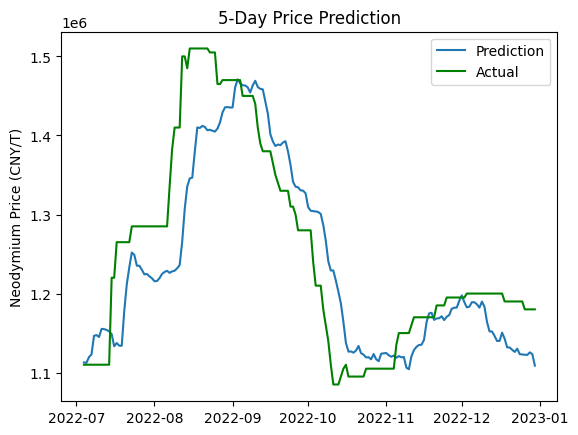

In [125]:
# Plot predicted values 
dates = df.index[-len(test_y):]
#plt.figure(figsize=(12, 6))
plt.plot(dates, inv_yhat, label="Prediction")
plt.plot(dates, inv_y, label="Actual", color="green")
plt.title("5-Day Price Prediction")
plt.ylabel("Neodymium Price (CNY/T)")
plt.legend()

### Prediction Period: Jul 2022 to Dec 2022

5-Day ARIMA Forecast Model

In [126]:
five_day_pred = pd.Series([])
y = df['Price (CNY/T)']
test_data = y[540 : 709]

for i in np.arange(540, 709, 1):

    training_window = y[i-34 : i-4]

    arima_model = auto_arima(training_window)
    arima_model.summary()

    five_day_pred = five_day_pred.append(arima_model.predict(n_periods = 5)[-1:])

C:\Users\brian\AppData\Local\Temp\ipykernel_11392\612820348.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  five_day_pred = pd.Series([])
C:\Users\brian\AppData\Local\Temp\ipykernel_11392\612820348.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  five_day_pred = five_day_pred.append(arima_model.predict(n_periods = 5)[-1:])
C:\Users\brian\AppData\Local\Temp\ipykernel_11392\612820348.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  five_day_pred = five_day_pred.append(arima_model.predict(n_periods = 5)[-1:])
C:\Users\brian\AppData\Local\Temp\ipykernel_11392\612820348.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use p

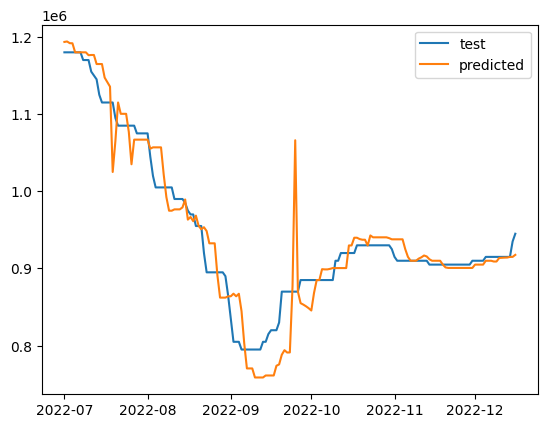

In [127]:
plt.plot(test_data.index, test_data, label='test')
plt.plot(test_data.index, five_day_pred, label = "predicted")
plt.legend()

plt.show()

In [128]:
# Calculate model performance 
mape = mean_absolute_percentage_error(test_data, five_day_pred)
mae = mean_absolute_error(test_data, five_day_pred)
rmse = sqrt(mean_squared_error(test_data, five_day_pred))

print('5-Day Forecast ARIMA Model')
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)

5-Day Forecast ARIMA Model
Test MAE: 20562.043
Test MAPE: 0.022
Test RMSE: 31207.482


5-Day BiLSTM Forecast Model (Baseline)

In [129]:
# Final features to be used
df2 = df.copy()[cols]
for c in df2.columns:
    df2[c+" (lag-1)"] = df2[c].shift(1)
df2["5 Days Later Price (CNY/T)"] = df2["Price (CNY/T)"].shift(-5)

In [130]:
# Scaling of features
scaler = MinMaxScaler(feature_range=(0, 1))
scaleddf = scaler.fit_transform(df2[["Price (CNY/T)", "Price (CNY/T) (lag-1)", "5 Days Later Price (CNY/T)"]])

In [131]:
# Splitting of explanatory features and target variable to train, validation and test sets

train_X, train_y = scaleddf[359:540, :-1], scaleddf[359:540, -1]
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, shuffle=True)
test_X, test_y = scaleddf[540:709, :-1], scaleddf[540:709, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [132]:
# Creation of Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [133]:
# Fitting data into model 
history = model.fit(train_X, train_y, epochs=150, batch_size=32, validation_data=(val_X, val_y), verbose=2, shuffle=False)

Epoch 1/150


4/4 - 4s - loss: 0.7104 - val_loss: 0.6876 - 4s/epoch - 1s/step
Epoch 2/150
4/4 - 0s - loss: 0.6555 - val_loss: 0.6316 - 40ms/epoch - 10ms/step
Epoch 3/150
4/4 - 0s - loss: 0.6020 - val_loss: 0.5744 - 47ms/epoch - 12ms/step
Epoch 4/150
4/4 - 0s - loss: 0.5412 - val_loss: 0.5152 - 47ms/epoch - 12ms/step
Epoch 5/150
4/4 - 0s - loss: 0.4856 - val_loss: 0.4530 - 47ms/epoch - 12ms/step
Epoch 6/150
4/4 - 0s - loss: 0.4209 - val_loss: 0.3869 - 40ms/epoch - 10ms/step
Epoch 7/150
4/4 - 0s - loss: 0.3551 - val_loss: 0.3160 - 55ms/epoch - 14ms/step
Epoch 8/150
4/4 - 0s - loss: 0.2817 - val_loss: 0.2393 - 46ms/epoch - 11ms/step
Epoch 9/150
4/4 - 0s - loss: 0.2000 - val_loss: 0.1557 - 47ms/epoch - 12ms/step
Epoch 10/150
4/4 - 0s - loss: 0.1186 - val_loss: 0.0713 - 44ms/epoch - 11ms/step
Epoch 11/150
4/4 - 0s - loss: 0.0564 - val_loss: 0.0545 - 49ms/epoch - 12ms/step
Epoch 12/150
4/4 - 0s - loss: 0.0681 - val_loss: 0.0777 - 69ms/epoch - 17ms/step
Epoch 13/150
4/4 - 0s - loss: 0.0851 - val_loss: 0.07

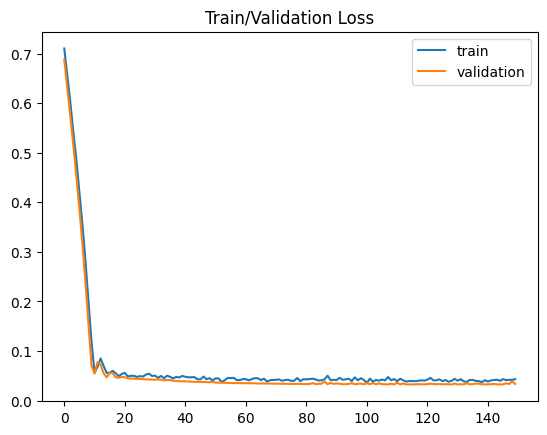

In [134]:
# Plot train/validation loss 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Train/Validation Loss")
plt.show()

In [135]:
# Predicting test set 
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = concatenate((test_X[:, :], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

6/6 [==============================] - 1s 0s/step


In [136]:
# Calculate model performance 
mape = mean_absolute_percentage_error(inv_y, inv_yhat)
mae = mean_absolute_error(inv_y, inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

print('5-Days Forecast BiLSTM Model')
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)

5-Days Forecast BiLSTM Model
Test MAE: 41039.736
Test MAPE: 0.045
Test RMSE: 47700.811


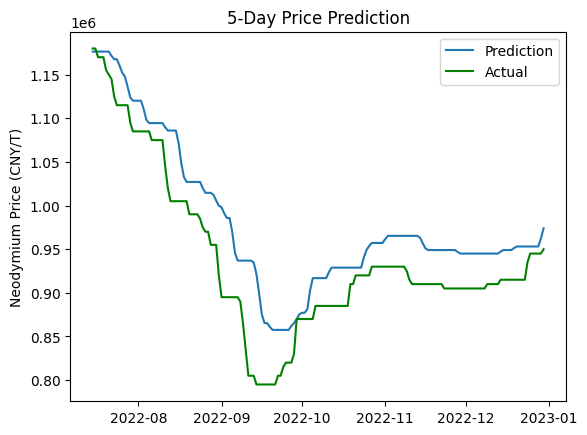

In [137]:
# Plot predicted values 
dates = df.index[-len(test_y):]
#plt.figure(figsize=(12, 6))
plt.plot(dates, inv_yhat, label="Prediction")
plt.plot(dates, inv_y, label="Actual", color="green")
plt.title("5-Day Price Prediction")
plt.ylabel("Neodymium Price (CNY/T)")
plt.legend()

5-Day BiLSTM Forecast Model

In [138]:
# Final features to be used
df2 = df.copy()[cols]
for c in df2.columns:
    df2[c+" (lag-1)"] = df2[c].shift(1)
df2["5 Days Later Price (CNY/T)"] = df2["Price (CNY/T)"].shift(-5)

In [139]:
# Scaling of features
scaler = MinMaxScaler(feature_range=(0, 1))
scaleddf = scaler.fit_transform(df2)

In [140]:
# Splitting of explanatory features and target variable to train, validation and test sets

train_X, train_y = scaleddf[359:540, :-1], scaleddf[359:540, -1]
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, shuffle=True)
test_X, test_y = scaleddf[540:709, :-1], scaleddf[540:709, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [141]:
# Creation of Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [142]:
# Fitting data into model 
history = model.fit(train_X, train_y, epochs=150, batch_size=32, validation_data=(val_X, val_y), verbose=2, shuffle=False)

Epoch 1/150


4/4 - 4s - loss: 0.6447 - val_loss: 0.5046 - 4s/epoch - 964ms/step
Epoch 2/150
4/4 - 0s - loss: 0.4018 - val_loss: 0.2581 - 31ms/epoch - 8ms/step
Epoch 3/150
4/4 - 0s - loss: 0.1738 - val_loss: 0.0776 - 47ms/epoch - 12ms/step
Epoch 4/150
4/4 - 0s - loss: 0.1272 - val_loss: 0.1502 - 47ms/epoch - 12ms/step
Epoch 5/150
4/4 - 0s - loss: 0.1697 - val_loss: 0.1313 - 53ms/epoch - 13ms/step
Epoch 6/150
4/4 - 0s - loss: 0.1301 - val_loss: 0.0766 - 35ms/epoch - 9ms/step
Epoch 7/150
4/4 - 0s - loss: 0.1064 - val_loss: 0.1029 - 47ms/epoch - 12ms/step
Epoch 8/150
4/4 - 0s - loss: 0.1185 - val_loss: 0.1085 - 47ms/epoch - 12ms/step
Epoch 9/150
4/4 - 0s - loss: 0.1107 - val_loss: 0.0793 - 47ms/epoch - 12ms/step
Epoch 10/150
4/4 - 0s - loss: 0.0953 - val_loss: 0.0748 - 47ms/epoch - 12ms/step
Epoch 11/150
4/4 - 0s - loss: 0.1035 - val_loss: 0.0786 - 47ms/epoch - 12ms/step
Epoch 12/150
4/4 - 0s - loss: 0.0965 - val_loss: 0.0703 - 47ms/epoch - 12ms/step
Epoch 13/150
4/4 - 0s - loss: 0.0868 - val_loss: 0.0

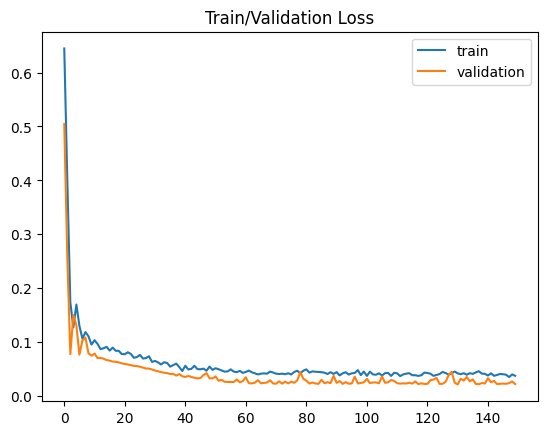

In [143]:
# Plot train/validation loss 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Train/Validation Loss")
plt.show()

In [144]:
# Predicting test set 
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = concatenate((test_X[:, :], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

6/6 [==============================] - 1s 2ms/step


In [145]:
# Calculate model performance 
mape = mean_absolute_percentage_error(inv_y, inv_yhat)
mae = mean_absolute_error(inv_y, inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

print('5-Days Forecast BiLSTM Model')
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)

5-Days Forecast BiLSTM Model
Test MAE: 34157.311
Test MAPE: 0.037
Test RMSE: 40066.146


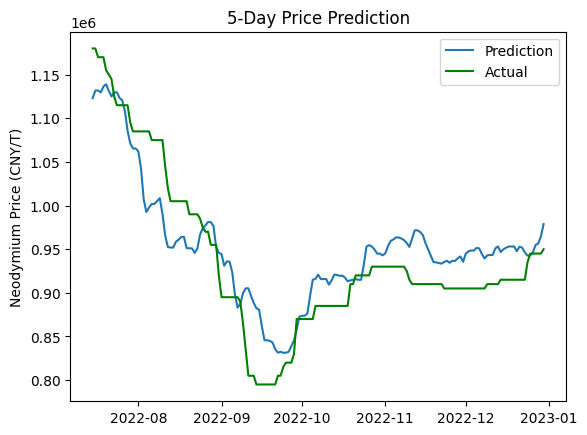

In [146]:
# Plot predicted values 
dates = df.index[-len(test_y):]
#plt.figure(figsize=(12, 6))
plt.plot(dates, inv_yhat, label="Prediction")
plt.plot(dates, inv_y, label="Actual", color="green")
plt.title("5-Day Price Prediction")
plt.ylabel("Neodymium Price (CNY/T)")
plt.legend()

In [147]:
# Final features to be used
df2 = df.copy()[cols]
for c in df2.columns:
    df2[c+" (lag-1)"] = df2[c].shift(1)
df2["5 Days Later Price (CNY/T)"] = df2["Price (CNY/T)"].shift(-5)

In [148]:
# Scaling of features
scaler = MinMaxScaler(feature_range=(0, 1))
scaleddf = scaler.fit_transform(df2[["Price (CNY/T)", "Price (CNY/T) (lag-1)", "5 Days Later Price (CNY/T)"]])

In [149]:
# Splitting of explanatory features and target variable to train, validation and test sets

train_X, train_y = scaleddf[359:540, :2], scaleddf[359:540, -1]
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, shuffle=True)
test_X, test_y = scaleddf[540:709, :2], scaleddf[540:709, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [150]:
# Creation of Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]))))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [151]:
# Fitting data into model 
history = model.fit(train_X, train_y, epochs=150, batch_size=32, validation_data=(val_X, val_y), verbose=2, shuffle=False)

Epoch 1/150


4/4 - 5s - loss: 0.6607 - val_loss: 0.6388 - 5s/epoch - 1s/step
Epoch 2/150
4/4 - 0s - loss: 0.5944 - val_loss: 0.5746 - 47ms/epoch - 12ms/step
Epoch 3/150
4/4 - 0s - loss: 0.5314 - val_loss: 0.5092 - 53ms/epoch - 13ms/step
Epoch 4/150
4/4 - 0s - loss: 0.4691 - val_loss: 0.4416 - 47ms/epoch - 12ms/step
Epoch 5/150
4/4 - 0s - loss: 0.3979 - val_loss: 0.3710 - 47ms/epoch - 12ms/step
Epoch 6/150
4/4 - 0s - loss: 0.3279 - val_loss: 0.2962 - 42ms/epoch - 11ms/step
Epoch 7/150
4/4 - 0s - loss: 0.2545 - val_loss: 0.2165 - 31ms/epoch - 8ms/step
Epoch 8/150
4/4 - 0s - loss: 0.1743 - val_loss: 0.1309 - 47ms/epoch - 12ms/step
Epoch 9/150
4/4 - 0s - loss: 0.0935 - val_loss: 0.0543 - 47ms/epoch - 12ms/step
Epoch 10/150
4/4 - 0s - loss: 0.0559 - val_loss: 0.0567 - 47ms/epoch - 12ms/step
Epoch 11/150
4/4 - 0s - loss: 0.0784 - val_loss: 0.0715 - 47ms/epoch - 12ms/step
Epoch 12/150
4/4 - 0s - loss: 0.0821 - val_loss: 0.0629 - 47ms/epoch - 12ms/step
Epoch 13/150
4/4 - 0s - loss: 0.0620 - val_loss: 0.048

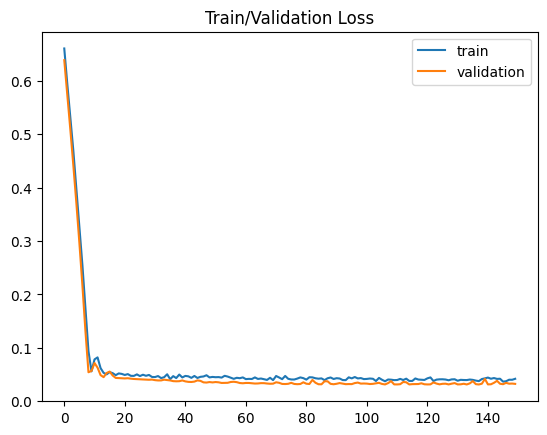

In [152]:
# Plot train/validation loss 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Train/Validation Loss")
plt.show()

In [153]:
# Predicting test set 
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = concatenate((test_X[:, :], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

6/6 [==============================] - 1s 3ms/step


In [154]:
# Calculate model performance 
mape = mean_absolute_percentage_error(inv_y, inv_yhat)
mae = mean_absolute_error(inv_y, inv_yhat)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

print('5-Days Forecast BiLSTM Model')
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)
print('Test RMSE: %.3f' % rmse)

5-Days Forecast BiLSTM Model
Test MAE: 43795.279
Test MAPE: 0.048
Test RMSE: 50117.282


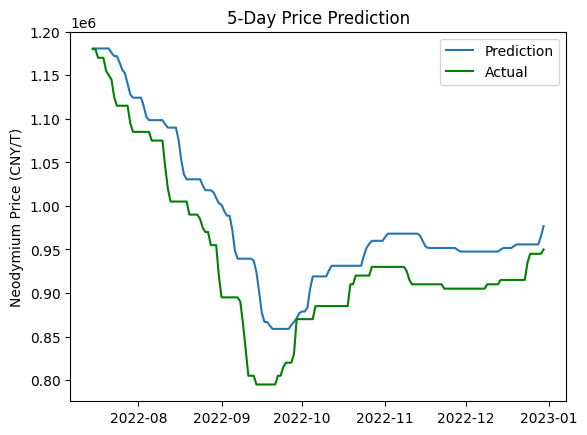

In [155]:
# Plot predicted values 
dates = df.index[-len(test_y):]
#plt.figure(figsize=(12, 6))
plt.plot(dates, inv_yhat, label="Prediction")
plt.plot(dates, inv_y, label="Actual", color="green")
plt.title("5-Day Price Prediction")
plt.ylabel("Neodymium Price (CNY/T)")
plt.legend()

In [156]:
zzzzz= {
0
: 
[32400000, 452, "No"],
1
: 
[2710800000, 461, "No"],
2
: 
[5130000000, 373, "No"],
3
: 
[7808400000, 389, "No"],
4
: 
[10400400000, 445, "No"],
5
: 
[13078800000, 466, "No"],
6
: 
[15670800000, 485, "No"],
7
: 
[18349200000, 481, "No"],
8
: 
[21027600000, 515, "No"],
9
: 
[23619600000, 564, "No"],
10
: 
[26298000000, 545, "No"],
11
: 
[28890000000, 570, "No"],
12
: 
[31568400000, 582, "No"],
13
: 
[34246800000, 618, "No"],
14
: 
[36666000000, 618, "No"],
15
: 
[39344400000, 681, "No"],
16
: 
[41936400000, 662, "No"],
17
: 
[44614800000, 618, "No"],
18
: 
[47206800000, 646, "No"],
19
: 
[49885200000, 706, "No"],
20
: 
[52563600000, 659, "No"],
21
: 
[55155600000, 625, "No"],
22
: 
[57834000000, 647, "No"],
23
: 
[60426000000, 710, "No"],
24
: 
[63104400000, 689, "No"],
25
: 
[65782800000, 698, "No"],
26
: 
[68288400000, 711, "No"],
27
: 
[70966800000, 640, "No"],
28
: 
[73558800000, 684, "No"],
29
: 
[76237200000, 677, "No"],
30
: 
[78829200000, 687, "No"],
31
: 
[81507600000, 681, "No"],
32
: 
[84186000000, 773, "No"],
33
: 
[86778000000, 767, "No"],
34
: 
[89456400000, 843, "No"],
35
: 
[92048400000, 735, "No"],
36
: 
[94726800000, 772, "No"],
37
: 
[97405200000, 781, "No"],
38
: 
[99824400000, 737, "No"],
39
: 
[102502800000, 725, "No"],
40
: 
[105094800000, 661, "No"],
41
: 
[107773200000, 660, "No"],
42
: 
[110365200000, 650, "No"],
43
: 
[113043600000, 601, "No"],
44
: 
[115722000000, 566, "No"],
45
: 
[118314000000, 561, "No"],
46
: 
[120992400000, 565, "No"],
47
: 
[123584400000, 547, "No"],
48
: 
[126262800000, 519, "No"],
49
: 
[128941200000, 523, "No"],
50
: 
[131360400000, 539, "No"],
51
: 
[134038800000, 572, "No"],
52
: 
[136630800000, 544, "No"],
53
: 
[139309200000, 590, "No"],
54
: 
[141901200000, 534, "No"],
55
: 
[144579600000, 534, "No"],
56
: 
[147258000000, 492, "No"],
57
: 
[149850000000, 511, "No"],
58
: 
[152528400000, 448, "No"],
59
: 
[155120400000, 450, "No"],
60
: 
[157798800000, 417, "No"],
61
: 
[160477200000, 416, "No"],
62
: 
[162896400000, 422, "No"],
63
: 
[165574800000, 477, "No"],
64
: 
[168166800000, 543, "No"],
65
: 
[170845200000, 579, "No"],
66
: 
[173437200000, 557, "No"],
67
: 
[176115600000, 569, "No"],
68
: 
[178794000000, 566, "No"],
69
: 
[181386000000, 556, "No"],
70
: 
[184064400000, 609, "No"],
71
: 
[186656400000, 680, "No"],
72
: 
[189334800000, 669, "No"],
73
: 
[192013200000, 603, "No"],
74
: 
[194518800000, 644, "No"],
75
: 
[197197200000, 591, "No"],
76
: 
[199789200000, 611, "No"],
77
: 
[202467600000, 570, "No"],
78
: 
[205059600000, 591, "No"],
79
: 
[207738000000, 664, "No"],
80
: 
[210416400000, 648, "No"],
81
: 
[213008400000, 696, "No"],
82
: 
[215686800000, 708, "No"],
83
: 
[218278800000, 735, "No"],
84
: 
[220957200000, 767, "No"],
85
: 
[223635600000, 825, "No"],
86
: 
[226054800000, 839, "No"],
87
: 
[228733200000, 872, "No"],
88
: 
[231325200000, 799, "No"],
89
: 
[234003600000, 807, "No"],
90
: 
[236595600000, 805, "No"],
91
: 
[239274000000, 755, "No"],
92
: 
[241952400000, 808, "No"],
93
: 
[244544400000, 842, "No"],
94
: 
[247222800000, 819, "No"],
95
: 
[249814800000, 829, "No"],
96
: 
[252493200000, 835, "No"],
97
: 
[255171600000, 795, "No"],
98
: 
[257590800000, 791, "No"],
99
: 
[260269200000, 814, "No"],
100
: 
[262861200000, 864, "No"],
101
: 
[265539600000, 857, "No"],
102
: 
[268131600000, 834, "No"],
103
: 
[270810000000, 789, "No"],
104
: 
[273488400000, 756, "No"],
105
: 
[276080400000, 812, "No"],
106
: 
[278758800000, 872, "No"],
107
: 
[281350800000, 798, "No"],
108
: 
[284029200000, 805, "No"],
109
: 
[286707600000, 754, "No"],
110
: 
[289126800000, 723, "No"],
111
: 
[291805200000, 793, "No"],
112
: 
[294397200000, 748, "No"],
113
: 
[297075600000, 727, "No"],
114
: 
[299667600000, 700, "No"],
115
: 
[302346000000, 715, "No"],
116
: 
[305024400000, 729, "No"],
117
: 
[307616400000, 727, "No"],
118
: 
[310294800000, 670, "No"],
119
: 
[312886800000, 597, "No"],
120
: 
[315565200000, 559, "No"],
121
: 
[318243600000, 592, "No"],
122
: 
[320749200000, 541, "No"],
123
: 
[323427600000, 474, "No"],
124
: 
[326019600000, 370, "No"],
125
: 
[328698000000, 469, "No"],
126
: 
[331290000000, 552, "No"],
127
: 
[333968400000, 636, "No"],
128
: 
[336646800000, 659, "No"],
129
: 
[339238800000, 596, "No"],
130
: 
[341917200000, 561, "No"],
131
: 
[344509200000, 562, "No"],
132
: 
[347187600000, 532, "No"],
133
: 
[349866000000, 511, "No"],
134
: 
[352285200000, 510, "No"],
135
: 
[354963600000, 514, "No"],
136
: 
[357555600000, 470, "No"],
137
: 
[360234000000, 467, "No"],
138
: 
[362826000000, 415, "No"],
139
: 
[365504400000, 431, "No"],
140
: 
[368182800000, 378, "No"],
141
: 
[370774800000, 338, "No"],
142
: 
[373453200000, 356, "No"],
143
: 
[376045200000, 382, "No"],
144
: 
[378723600000, 457, "No"],
145
: 
[381402000000, 368, "No"],
146
: 
[383821200000, 365, "No"],
147
: 
[386499600000, 374, "No"],
148
: 
[389091600000, 339, "No"],
149
: 
[391770000000, 384, "No"],
150
: 
[394362000000, 370, "No"],
151
: 
[397040400000, 375, "No"],
152
: 
[399718800000, 407, "No"],
153
: 
[402310800000, 481, "No"],
154
: 
[404989200000, 480, "No"],
155
: 
[407581200000, 554, "No"],
156
: 
[410259600000, 521, "No"],
157
: 
[412938000000, 582, "No"],
158
: 
[415357200000, 562, "No"],
159
: 
[418035600000, 596, "No"],
160
: 
[420627600000, 638, "No"],
161
: 
[423306000000, 664, "No"],
162
: 
[425898000000, 651, "No"],
163
: 
[428576400000, 606, "No"],
164
: 
[431254800000, 572, "No"],
165
: 
[433846800000, 608, "No"],
166
: 
[436525200000, 632, "No"],
167
: 
[439117200000, 644, "No"],
168
: 
[441795600000, 773, "No"],
169
: 
[444474000000, 691, "No"],
170
: 
[446979600000, 696, "No"],
171
: 
[449658000000, 641, "No"],
172
: 
[452250000000, 639, "No"],
173
: 
[454928400000, 615, "No"],
174
: 
[457520400000, 630, "No"],
175
: 
[460198800000, 619, "No"],
176
: 
[462877200000, 567, "No"],
177
: 
[465469200000, 662, "No"],
178
: 
[468147600000, 687, "No"],
179
: 
[470739600000, 597, "No"],
180
: 
[473418000000, 597, "No"],
181
: 
[476096400000, 645, "No"],
182
: 
[478515600000, 682, "No"],
183
: 
[481194000000, 671, "No"],
184
: 
[483786000000, 620, "No"],
185
: 
[486464400000, 678, "No"],
186
: 
[489056400000, 722, "No"],
187
: 
[491734800000, 766, "No"],
188
: 
[494413200000, 726, "No"],
189
: 
[497005200000, 678, "No"],
190
: 
[499683600000, 655, "No"],
191
: 
[502275600000, 733, "No"],
192
: 
[504954000000, 721, "No"],
193
: 
[507632400000, 733, "No"],
194
: 
[510051600000, 728, "No"],
195
: 
[512730000000, 880, "No"],
196
: 
[515322000000, 857, "No"],
197
: 
[518000400000, 789, "No"],
198
: 
[520592400000, 728, "No"],
199
: 
[523270800000, 698, "No"],
200
: 
[525949200000, 621, "No"],
201
: 
[528541200000, 763, "No"],
202
: 
[531219600000, 669, "No"],
203
: 
[533811600000, 707, "No"],
204
: 
[536490000000, 784, "No"],
205
: 
[539168400000, 709, "No"],
206
: 
[541587600000, 732, "No"],
207
: 
[544266000000, 713, "No"],
208
: 
[546858000000, 735, "No"],
209
: 
[549536400000, 651, "No"],
210
: 
[552128400000, 637, "No"],
211
: 
[554806800000, 658, "No"],
212
: 
[557485200000, 657, "No"],
213
: 
[560077200000, 666, "No"],
214
: 
[562755600000, 650, "No"],
215
: 
[565347600000, 625, "No"],
216
: 
[568026000000, 595, "No"],
217
: 
[570704400000, 585, "No"],
218
: 
[573210000000, 663, "No"],
219
: 
[575888400000, 669, "No"],
220
: 
[578480400000, 699, "No"],
221
: 
[581158800000, 684, "No"],
222
: 
[583750800000, 717, "No"],
223
: 
[586429200000, 679, "No"],
224
: 
[589107600000, 688, "No"],
225
: 
[591699600000, 703, "No"],
226
: 
[594378000000, 718, "No"],
227
: 
[596970000000, 628, "No"],
228
: 
[599648400000, 658, "No"],
229
: 
[602326800000, 719, "No"],
230
: 
[604746000000, 622, "No"],
231
: 
[607424400000, 567, "No"],
232
: 
[610016400000, 608, "No"],
233
: 
[612694800000, 656, "No"],
234
: 
[615286800000, 642, "No"],
235
: 
[617965200000, 731, "No"],
236
: 
[620643600000, 697, "No"],
237
: 
[623235600000, 639, "No"],
238
: 
[625914000000, 645, "No"],
239
: 
[628506000000, 684, "No"],
240
: 
[631184400000, 630, "No"],
241
: 
[633862800000, 620, "No"],
242
: 
[636282000000, 591, "No"],
243
: 
[638960400000, 574, "No"],
244
: 
[641552400000, 542, "No"],
245
: 
[644230800000, 534, "No"],
246
: 
[646822800000, 545, "No"],
247
: 
[649501200000, 542, "No"],
248
: 
[652179600000, 528, "No"],
249
: 
[654771600000, 496, "No"],
250
: 
[657450000000, 465, "No"],
251
: 
[660042000000, 493, "No"],
252
: 
[662720400000, 464, "No"],
253
: 
[665398800000, 401, "No"],
254
: 
[667818000000, 482, "No"],
255
: 
[670496400000, 507, "No"],
256
: 
[673088400000, 508, "No"],
257
: 
[675766800000, 517, "No"],
258
: 
[678358800000, 516, "No"],
259
: 
[681037200000, 511, "No"],
260
: 
[683715600000, 526, "No"],
261
: 
[686307600000, 487, "No"],
262
: 
[688986000000, 524, "No"],
263
: 
[691578000000, 575, "No"],
264
: 
[694256400000, 558, "No"],
265
: 
[696934800000, 676, "No"],
266
: 
[699440400000, 639, "No"],
267
: 
[702118800000, 554, "No"],
268
: 
[704710800000, 546, "No"],
269
: 
[707389200000, 554, "No"],
270
: 
[709981200000, 596, "No"],
271
: 
[712659600000, 627, "No"],
272
: 
[715338000000, 636, "No"],
273
: 
[717930000000, 650, "No"],
274
: 
[720608400000, 621, "No"],
275
: 
[723200400000, 614, "No"],
276
: 
[725878800000, 650, "No"],
277
: 
[728557200000, 596, "No"],
278
: 
[730976400000, 604, "No"],
279
: 
[733654800000, 602, "No"],
280
: 
[736246800000, 701, "No"],
281
: 
[738925200000, 626, "No"],
282
: 
[741517200000, 653, "No"],
283
: 
[744195600000, 655, "No"],
284
: 
[746874000000, 645, "No"],
285
: 
[749466000000, 726, "No"],
286
: 
[752144400000, 704, "No"],
287
: 
[754736400000, 769, "No"],
288
: 
[757414800000, 812, "No"],
289
: 
[760093200000, 619, "No"],
290
: 
[762512400000, 686, "No"],
291
: 
[765190800000, 747, "No"],
292
: 
[767782800000, 692, "No"],
293
: 
[770461200000, 691, "No"],
294
: 
[773053200000, 621, "No"],
295
: 
[775731600000, 628, "No"],
296
: 
[778410000000, 656, "No"],
297
: 
[781002000000, 677, "No"],
298
: 
[783680400000, 715, "No"],
299
: 
[786272400000, 646, "No"],
300
: 
[788950800000, 629, "No"],
301
: 
[791629200000, 626, "No"],
302
: 
[794048400000, 559, "No"],
303
: 
[796726800000, 616, "No"],
304
: 
[799318800000, 621, "No"],
305
: 
[801997200000, 674, "No"],
306
: 
[804589200000, 725, "No"],
307
: 
[807267600000, 765, "No"],
308
: 
[809946000000, 701, "No"],
309
: 
[812538000000, 678, "No"],
310
: 
[815216400000, 696, "No"],
311
: 
[817808400000, 664, "No"],
312
: 
[820486800000, 709, "No"],
313
: 
[823165200000, 714, "No"],
314
: 
[825670800000, 769, "No"],
315
: 
[828349200000, 721, "No"],
316
: 
[830941200000, 736, "No"],
317
: 
[833619600000, 746, "No"],
318
: 
[836211600000, 721, "No"],
319
: 
[838890000000, 770, "No"],
320
: 
[841568400000, 826, "No"],
321
: 
[844160400000, 770, "No"],
322
: 
[846838800000, 720, "No"],
323
: 
[849430800000, 771, "No"],
324
: 
[852109200000, 805, "No"],
325
: 
[854787600000, 830, "No"],
326
: 
[857206800000, 801, "No"],
327
: 
[859885200000, 831, "No"],
328
: 
[862477200000, 744, "No"],
329
: 
[865155600000, 760, "No"],
330
: 
[867747600000, 793, "No"],
331
: 
[870426000000, 805, "No"],
332
: 
[873104400000, 815, "No"],
333
: 
[875696400000, 840, "No"],
334
: 
[878374800000, 800, "No"],
335
: 
[880966800000, 864, "No"],
336
: 
[883645200000, 793, "No"],
337
: 
[886323600000, 872, "No"],
338
: 
[888742800000, 866, "No"],
339
: 
[891421200000, 836, "No"],
340
: 
[894013200000, 866, "No"],
341
: 
[896691600000, 887, "No"],
342
: 
[899283600000, 923, "No"],
343
: 
[901962000000, 876, "No"],
344
: 
[904640400000, 846, "No"],
345
: 
[907232400000, 864, "No"],
346
: 
[909910800000, 893, "No"],
347
: 
[912502800000, 995, "No"],
348
: 
[915181200000, 949, "No"],
349
: 
[917859600000, 875, "No"],
350
: 
[920278800000, 848, "No"],
351
: 
[922957200000, 863, "No"],
352
: 
[925549200000, 918, "No"],
353
: 
[928227600000, 888, "No"],
354
: 
[930819600000, 923, "No"],
355
: 
[933498000000, 900, "No"],
356
: 
[936176400000, 893, "No"],
357
: 
[938768400000, 826, "No"],
358
: 
[941446800000, 872, "No"],
359
: 
[944038800000, 863, "No"],
360
: 
[946717200000, 873, "No"],
361
: 
[949395600000, 873, "No"],
362
: 
[951901200000, 856, "No"],
363
: 
[954579600000, 900, "No"],
364
: 
[957171600000, 841, "No"],
365
: 
[959850000000, 857, "No"],
366
: 
[962442000000, 793, "No"],
367
: 
[965120400000, 887, "No"],
368
: 
[967798800000, 848, "No"],
369
: 
[970390800000, 912, "No"],
370
: 
[973069200000, 933, "No"],
371
: 
[975661200000, 880, "No"],
372
: 
[978339600000, 983, "No"],
373
: 
[981018000000, 936, "No"],
374
: 
[983437200000, 963, "No"],
375
: 
[986115600000, 939, "No"],
376
: 
[988707600000, 909, "No"],
377
: 
[991386000000, 885, "No"],
378
: 
[993978000000, 882, "No"],
379
: 
[996656400000, 880, "No"],
380
: 
[999334800000, 866, "No"],
381
: 
[1001926800000, 853, "No"],
382
: 
[1004605200000, 871, "No"],
383
: 
[1007197200000, 924, "No"],
384
: 
[1009875600000, 979, "No"],
385
: 
[1012554000000, 880, "No"],
386
: 
[1014973200000, 948, "No"],
387
: 
[1017651600000, 923, "No"],
388
: 
[1020243600000, 936, "No"],
389
: 
[1022922000000, 978, "No"],
390
: 
[1025514000000, 957, "No"],
391
: 
[1028192400000, 956, "No"],
392
: 
[1030870800000, 1014, "No"],
393
: 
[1033462800000, 1044, "No"],
394
: 
[1036141200000, 1006, "No"],
395
: 
[1038733200000, 1024, "No"],
396
: 
[1041411600000, 1048, "No"],
397
: 
[1044090000000, 999, "No"],
398
: 
[1046509200000, 936, "No"],
399
: 
[1049187600000, 999, "No"],
400
: 
[1051779600000, 1012, "No"],
401
: 
[1054458000000, 1078, "No"],
402
: 
[1057050000000, 1193, "No"],
403
: 
[1059728400000, 1168, "No"],
404
: 
[1062406800000, 1206, "No"],
405
: 
[1064998800000, 1131, "No"],
406
: 
[1067677200000, 1144, "No"],
407
: 
[1070269200000, 1093, "No"],
408
: 
[1072947600000, 1129, "No"],
409
: 
[1075626000000, 1165, "No"],
410
: 
[1078131600000, 1159, "No"],
411
: 
[1080810000000, 1276, "No"],
412
: 
[1083402000000, 1186, "No"],
413
: 
[1086080400000, 1241, "No"],
414
: 
[1088672400000, 1180, "No"],
415
: 
[1091350800000, 1088, "No"],
416
: 
[1094029200000, 1175, "No"],
417
: 
[1096621200000, 1214, "No"],
418
: 
[1099299600000, 1305, "No"],
419
: 
[1101891600000, 1179, "No"],
420
: 
[1104570000000, 1242, "No"],
421
: 
[1107248400000, 1203, "No"],
422
: 
[1109667600000, 1319, "No"],
423
: 
[1112346000000, 1328, "No"],
424
: 
[1114938000000, 1260, "No"],
425
: 
[1117616400000, 1286, "No"],
426
: 
[1120208400000, 1274, "No"],
427
: 
[1122886800000, 1389, "No"],
428
: 
[1125565200000, 1255, "No"],
429
: 
[1128157200000, 1244, "No"],
430
: 
[1130835600000, 1336, "No"],
431
: 
[1133427600000, 1214, "No"],
432
: 
[1136106000000, 1239, "No"],
433
: 
[1138784400000, 1174, "No"],
434
: 
[1141203600000, 1061, "No"],
435
: 
[1143882000000, 1116, "No"],
436
: 
[1146474000000, 1123, "No"],
437
: 
[1149152400000, 1086, "No"],
438
: 
[1151744400000, 1074, "No"],
439
: 
[1154422800000, 965, "No"],
440
: 
[1157101200000, 1035, "No"],
441
: 
[1159693200000, 1016, "No"],
442
: 
[1162371600000, 941, "No"],
443
: 
[1164963600000, 1003, "No"],
444
: 
[1167642000000, 998, "No"],
445
: 
[1170320400000, 891, "No"],
446
: 
[1172739600000, 828, "No"],
447
: 
[1175418000000, 833, "No"],
448
: 
[1178010000000, 887, "No"],
449
: 
[1180688400000, 842, "No"],
450
: 
[1183280400000, 793, "No"],
451
: 
[1185958800000, 778, "No"],
452
: 
[1188637200000, 699, "No"],
453
: 
[1191229200000, 686, "No"],
454
: 
[1193907600000, 727, "No"],
455
: 
[1196499600000, 641, "No"],
456
: 
[1199178000000, 605, "No"],
457
: 
[1204124400000, 588, "No"],
458
: 
[1206540000000, 590, "No"],
459
: 
[1209045600000, 562, "No"],
460
: 
[1211900400000, 526, "No"],
461
: 
[1214402400000, 512, "No"],
462
: 
[1216994400000, 530, "No"],
463
: 
[1219759200000, 515, "No"],
464
: 
[1222351200000, 460, "No"],
465
: 
[1225116000000, 464, "No"],
466
: 
[1227711600000, 433, "No"],
467
: 
[1230044400000, 407, "No"],
468
: 
[1233241200000, 331, "No"],
469
: 
[1235660400000, 309, "No"],
470
: 
[1237989600000, 358, "No"],
471
: 
[1240581600000, 351, "No"],
472
: 
[1243519200000, 344, "No"],
473
: 
[1245852000000, 346, "No"],
474
: 
[1248703200000, 395, "No"],
475
: 
[1251295200000, 426, "No"],
476
: 
[1253887200000, 417, "No"],
477
: 
[1256738400000, 405, "No"],
478
: 
[1259161200000, 400, "No"],
479
: 
[1261580400000, 370, "No"],
480
: 
[1264604400000, 348, "No"],
481
: 
[1267023600000, 315, "No"],
482
: 
[1269439200000, 324, "No"],
483
: 
[1272031200000, 439, "No"],
484
: 
[1274882400000, 446, "No"],
485
: 
[1277301600000, 267, "No"],
486
: 
[1280152800000, 315, "No"],
487
: 
[1282744800000, 288, "No"],
488
: 
[1285336800000, 288, "No"],
489
: 
[1288188000000, 308, "No"],
490
: 
[1290610800000, 275, "No"],
491
: 
[1293116400000, 280, "No"],
492
: 
[1296054000000, 325, "No"],
493
: 
[1298559600000, 301, "No"],
494
: 
[1300888800000, 270, "No"],
495
: 
[1303740000000, 301, "No"],
496
: 
[1306245600000, 326, "No"],
497
: 
[1308837600000, 315, "No"],
498
: 
[1311688800000, 300, "No"],
499
: 
[1314108000000, 302, "No"],
500
: 
[1317045600000, 296, "No"],
501
: 
[1319637600000, 303, "No"],
502
: 
[1322492400000, 310, "No"],
503
: 
[1324652400000, 314, "No"],
504
: 
[1327590000000, 324, "No"],
505
: 
[1330095600000, 318, "No"],
506
: 
[1332511200000, 353, "No"],
507
: 
[1335276000000, 332, "No"],
508
: 
[1337781600000, 343, "No"],
509
: 
[1340632800000, 382, "No"],
510
: 
[1343224800000, 359, "No"],
511
: 
[1345730400000, 374, "No"],
512
: 
[1348668000000, 368, "No"],
513
: 
[1351087200000, 369, "No"],
514
: 
[1354114800000, 361, "No"],
515
: 
[1356620400000, 398, "No"],
516
: 
[1359126000000, 378, "No"],
517
: 
[1361890800000, 431, "No"],
518
: 
[1364306400000, 411, "No"],
519
: 
[1366725600000, 444, "No"],
520
: 
[1369317600000, 466, "No"],
521
: 
[1372168800000, 459, "No"],
522
: 
[1374674400000, 455, "No"],
523
: 
[1377266400000, 390, "No"],
524
: 
[1380117600000, 379, "No"],
525
: 
[1386169200000, 354, "No"],
526
: 
[1386169200000, 474, "No"],
527
: 
[1387897200000, 445, "No"],
528
: 
[1390834800000, 427, "No"],
529
: 
[1393426800000, 455, "No"],
530
: 
[1395756000000, 449, "No"],
531
: 
[1398261600000, 407, "No"],
532
: 
[1400853600000, 425, "No"],
533
: 
[1403618400000, 442, "No"],
534
: 
[1406210400000, 422, "No"],
535
: 
[1408975200000, 427, "No"],
536
: 
[1411567200000, 466, "No"],
537
: 
[1414159200000, 455, "No"],
538
: 
[1417014000000, 445, "No"],
539
: 
[1419346800000, 431, "No"],
540
: 
[1422370800000, 482, "No"],
541
: 
[1424876400000, 500, "No"],
542
: 
[1427205600000, 543, "No"],
543
: 
[1429797600000, 484, "No"],
544
: 
[1432648800000, 534, "No"],
545
: 
[1435068000000, 517, "No"],
546
: 
[1437746400000, 481, "No"],
547
: 
[1440511200000, 522, "No"],
548
: 
[1443103200000, 529, "No"],
549
: 
[1445868000000, 447, "No"],
550
: 
[1448463600000, 470, "No"],
551
: 
[1450882800000, 491, "No"],
552
: 
[1453906800000, 544, "No"],
553
: 
[1456326000000, 502, "No"],
554
: 
[1458741600000, 519, "No"],
555
: 
[1461592800000, 531, "No"],
556
: 
[1464098400000, 586, "No"],
557
: 
[1466690400000, 572, "No"],
558
: 
[1469541600000, 582, "No"],
559
: 
[1471960800000, 659, "No"],
560
: 
[1474898400000, 575, "No"],
561
: 
[1477490400000, 574, "No"],
562
: 
[1479913200000, 563, "No"],
563
: 
[1482505200000, 598, "No"],
564
: 
[1485442800000, 535, "No"],
565
: 
[1487948400000, 558, "No"],
566
: 
[1490277600000, 587, "No"],
567
: 
[1493128800000, 642, "No"],
568
: 
[1495548000000, 593, "No"],
569
: 
[1498226400000, 605, "No"],
570
: 
[1501077600000, 630, "No"],
571
: 
[1503496800000, 580, "No"],
572
: 
[1506434400000, 561, "No"],
573
: 
[1508940000000, 645, "No"],
574
: 
[1511794800000, 624, "No"],
575
: 
[1513954800000, 689, "No"],
576
: 
[1516892400000, 643, "No"],
577
: 
[1519657200000, 622, "No"],
578
: 
[1521813600000, 667, "No"],
579
: 
[1524578400000, 672, "No"],
580
: 
[1527084000000, 646, "No"],
581
: 
[1529935200000, 666, "No"],
582
: 
[1532527200000, 638, "No"],
583
: 
[1535032800000, 608, "No"],
584
: 
[1537970400000, 585, "No"],
585
: 
[1540389600000, 597, "No"],
586
: 
[1543417200000, 562, "No"],
587
: 
[1548946800000, 599, "No"],
588
: 
[1551798000000, 652, "No"],
589
: 
[1552572000000, 636, "No"],
590
: 
[1553868000000, 662, "No"],
591
: 
[1556028000000, 723, "No"],
592
: 
[1558620000000, 679, "No"],
593
: 
[1561471200000, 604, "No"],
594
: 
[1563976800000, 728, "No"],
595
: 
[1566568800000, 666, "No"],
596
: 
[1569420000000, 706, "No"],
597
: 
[1571925600000, 738, "No"],
598
: 
[1574780400000, 710, "No"],
599
: 
[1577113200000, 697, "No"],
600
: 
[1580137200000, 708, "No"],
601
: 
[1582729200000, 800, "No"],
602
: 
[1585058400000, 741, "No"],
603
: 
[1587650400000, 619, "No"],
604
: 
[1590501600000, 580, "No"],
605
: 
[1592920800000, 682, "No"],
606
: 
[1595599200000, 791, "No"],
607
: 
[1598364000000, 965, "No"],
608
: 
[1600956000000, 994, "No"],
609
: 
[1603720800000, 1002, "No"],
610
: 
[1606316400000, 945, "No"],
611
: 
[1608735600000, 829, "No"],
612
: 
[1611846000000, 885, "No"],
613
: 
[1614178800000, 948, "No"],
614
: 
[1616508000000, 846, "No"],
615
: 
[1619186400000, 917, "No"],
616
: 
[1621951200000, 817, "No"],
617
: 
[1624456800000, 724, "No"],
618
: 
[1627308000000, 701, "No"],
619
: 
[1629813600000, 729, "No"],
620
: 
[1632492000000, 702, "No"],
621
: 
[1635256800000, 742, "No"],
622
: 
[1637766000000, 662, "No"],
623
: 
[1640271600000, 725, "No"],
624
: 
[1643209200000, 839, "No"],
625
: 
[1645714800000, 788, "No"],
626
: 
[1648044000000, 835, "No"],
627
: 
[1650981600000, 709, "No"],
628
: 
[1653400800000, 629, "No"],
629
: 
[1656079200000, 642, "No"],
630
: 
[1658844000000, 585, "No"],
631
: 
[1661263200000, 532, "No"],
632
: 
[1664287200000, 677, "No"],
633
: 
[1666792800000, 588, "No"],
634
: 
[1669215600000, 605, "No"],
635
: 
[1671807600000, 602, "No"],
636
: 
[1674745200000, 625, "No"],
637
: 
[1677250800000, 633, "No"],
638
: 
[1679580000000, 640, "No"],
}